<a href="https://colab.research.google.com/github/TheBestBot/AE352Project/blob/main/DroneCodeFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sympy import *
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


## Plotting Code

In [ ]:
from matplotlib.cm import get_cmap

# Styling function
def plot_style():
    plt.rcParams['axes.linewidth'] = 1.0
    plt.rcParams["font.family"] = "Times New Roman"
    parameters = {
        'axes.labelsize': 6,
        'xtick.labelsize': 6,
        'ytick.labelsize': 3,
        'figure.dpi': 600
    }
    plt.rcParams.update(parameters)

# Apply styling
plot_style()

# Get Set2 colormap
cmap = get_cmap("Set2")
colors = [cmap(i) for i in range(5)]

def motion_plot(motion_index, time, motion, labels, color, y):
    fig, ax = plt.subplots(figsize=(6, 5))

    # Plot different motion variables over time

    for i in range(len(motion)):
        ax.plot(time, motion[i], label=labels[i], color=color[i], linewidth=4)

    # Labels and ticks
    ax.set_ylabel(motion_index, fontsize=10, labelpad=0)
    ax.set_xlabel("Time (seconds)", fontsize=10, labelpad=0)

    # Set more ticks
    ax.xaxis.set_major_locator(plt.MultipleLocator(20))  # Major ticks every 50 seconds
    ax.tick_params(axis='x', which='major', labelsize=8)  # Font size for major x-axis ticks
    ax.xaxis.set_minor_locator(plt.MultipleLocator(5))   # Minor ticks every 10 seconds

    y_max, y_min = y
    ax.yaxis.set_major_locator(plt.MultipleLocator(y_max))  # Major ticks every 10,000
    ax.tick_params(axis='y', which='major', labelsize=8)  # Font size for major y-axis ticks
    ax.yaxis.set_minor_locator(plt.MultipleLocator(y_min))  # Minor ticks every 2000

    # Major and minor gridlines
    ax.grid(True, which='major', linestyle='-', linewidth=0.5, color='gray', alpha=0.7)
    ax.grid(True, which='minor', linestyle='-', linewidth=0.3, color='gray', alpha=0.3)

    # Ensure gridlines are behind the lines
    ax.set_axisbelow(True)

    # Add legend
    ax.legend(fontsize=10, loc='upper left')

    # Adjust layout
    plt.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.15)

    plt.fixsize = (6, 5)
    # Save and show the plot
    plt.show()
motion_list = np.array(["Position (m)", "Orientation (rad/s)", "Velocity", "Angular Velocity (rad/s^2)", "Torque (Nm)", "Force (N)"])

<ipython-input-17-3f9f6fd9dd60>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Set2")


## EOM

In [ ]:
# Gravity
g = 9.81 # m/s

# Lifting Torque Coefficient
k_F = 6.36105e-9

# Rotational Torque Coefficient
k_M = 4.65133e-11

# Drone Dimensions
mass_body = 1 # kg
length_body = 0.08787 # m
width_body = length_body
height_body = 0.160 # m

# Rotor Arm Dimensions
mass_arm = 0.261 # kg
length_arm = 0.168565 # m

# Distance from center of mass to rotors
length_rz = 0.05



In [35]:
"""
Moments of Inertia:
    Drone is simplified into one rectangular prism for the body
    and four rectangular prisms symmetric about the x-axis for
    the arms.
"""
mass_total = 4*mass_arm + mass_body

# Moment of Inertia for the body
I_xx_body = 1/12 * mass_body*(width_body**2 + height_body**2)
I_yy_body = 1/12 * mass_body*(length_body**2 + height_body**2)
I_zz_body = 1/12 * mass_body *(width_body**2 + length_body**2)

# Parallel Axis Theorem must be used here to account for the distance between arm and body axes
I_xx_arm = 0
I_yy_arm = 1/12 * mass_arm * length_arm**2 + mass_arm *(length_arm/2 + length_body/2)**2
I_zz_arm = I_yy_arm

# Add them together
Ixx = 4*I_xx_arm + I_xx_body
Iyy = 4*I_yy_arm + I_yy_body
Izz = 4*I_zz_arm + I_zz_body

2.044


In [ ]:

def u(sigma_1, sigma_2, sigma_3, sigma_4):
    """
    Sigma values here are the respective rotor speeds; it is important to note that
    Force is proportional to the square of the rotor speed, therefore Torque is proportional
    to rotor speed squared times the distance from the center of mass to the rotor.
    """
    tau_x = length_rz * k_F * (-sigma_2**2 + sigma_4**2)
    tau_y = length_rz * k_F * (-sigma_1**2 + sigma_3**2)
    tau_z = length_rz * k_M * (sigma_1**2 - sigma_2**2 + sigma_3**2 - sigma_4**2)

    f_z = k_F * (sigma_1**2 + sigma_2**2 + sigma_3**2 + sigma_4**2)

    return tau_x, tau_y, tau_z, f_z



In [ ]:
def quad_EOM(t, x, u, params):

    #must be first-order ODES
    """
    Arguments:
        x : state vector :
        [px, py, pz, phi, theta, psi,
         v_x, v_y, v_z, omega_x, omega_y, omega_z]

        u : control input :
        [tau_x, tau_y, tau_z, f_z]

        t : time
        p : various vector parameters :
        [m, Ixx, Iyy, Izz]
    """
    ### Initialize State, Control, and Parameter Variables
    phi, theta, psi, v_x, v_y, v_z, omega_x, omega_y, omega_z = x[3:12]

    tau_x, tau_y, tau_z, f_z = u

    mass_total, Ixx, Iyy, Izz = params

    I = np.diag([Ixx, Iyy, Izz])

    ### Position Update
    R_pos = np.array([[np.cos(psi)*np.cos(theta), np.cos(psi)*np.sin(theta)*np.sin(phi) - np.sin(psi)*np.cos(phi), np.cos(psi)*np.sin(theta)*np.cos(phi) + np.sin(psi)*np.sin(phi)],
                      [np.sin(psi)*np.cos(theta), np.sin(psi)*np.sin(theta)*np.sin(phi) + np.cos(psi)*np.cos(phi), np.sin(psi)*np.sin(theta)*np.cos(phi) - np.cos(psi)*np.sin(phi)],
                      [-np.sin(theta), np.cos(theta)*np.sin(phi), np.cos(theta)*np.cos(phi)]])

    p_dot = R_pos@np.array([v_x, v_y, v_z])

    ### Orientation Update
    R_angles = np.array([[1, np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],
                         [0, np.cos(phi), -np.sin(phi)],
                         [0, np.sin(phi)/np.cos(theta), np.cos(phi)/np.cos(theta)]])

    angles_dot = R_angles@np.array([omega_x, omega_y, omega_z])

    ### Translational Velocity Update
    R_velocities = np.array([np.cos(psi)*np.sin(theta)*np.cos(phi) + np.sin(psi)*np.sin(phi),
                             np.sin(psi)*np.sin(theta)*np.cos(phi) - np.cos(psi)*np.sin(phi),
                             np.cos(theta)*np.cos(phi)])

    vel_dot = -g*np.array([0, 0, 1]) + f_z/mass_total*R_velocities


    ### Angular Velocity Update
    v_dot = np.linalg.inv(I)@(np.cross(-np.array([omega_x, omega_y, omega_z]), np.array([Ixx*omega_x, Iyy*omega_y, Izz*omega_z])) + np.array([tau_x, tau_y, tau_z]))

    dR_angles = np.array([[0, angles_dot[0]*np.cos(phi)*np.tan(theta) + angles_dot[1]*np.sin(phi)/(np.cos(theta))**2, -angles_dot[0]*np.sin(phi)*np.cos(theta) + angles_dot[1]*np.cos(phi)/(np.cos(theta))**2],
                          [0, -angles_dot[0]*np.sin(phi), -angles_dot[0]*np.cos(phi)],
                          [0, angles_dot[0]*np.cos(phi)/np.cos(theta) + angles_dot[0]*np.sin(phi)*np.tan(theta)/np.cos(theta), -angles_dot[0]*sin(phi)/np.cos(theta) + angles_dot[1]*np.cos(phi)*np.tan(theta)/np.cos(theta)]])

    omega_dot = dR_angles@np.array([omega_x, omega_y, omega_z]) + R_angles@v_dot

    EOM = np.concatenate([p_dot, angles_dot, vel_dot, omega_dot])

    return EOM

## Hover

In [36]:
### Rotor Speeds
sigma_val = np.sqrt(mass_total*g/(k_F*4))

### Rotors 1 and 3 spin clockwise
sigma1 = sigma_val
sigma3 = sigma_val

### Rotors 2 and 4 spin counter-clockwise
sigma2 = sigma_val
sigma4 = sigma_val



28072.46500465776


In [ ]:
### Initial Conditions: State, Input, and Parameters
x0 = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
u_val = u(sigma1, sigma2, sigma3, sigma4)
params = np.array([mass_total, Ixx, Iyy, Izz])

### Arguments for solve_ivp
ar = (u_val, params)
t = (0, 120)

sol = solve_ivp(quad_EOM, t, x0, max_step = 0.1, args = ar)
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-04 ...  1.199e+02  1.200e+02]
        y: [[ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            ...
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 7220
     njev: 0
      nlu: 0

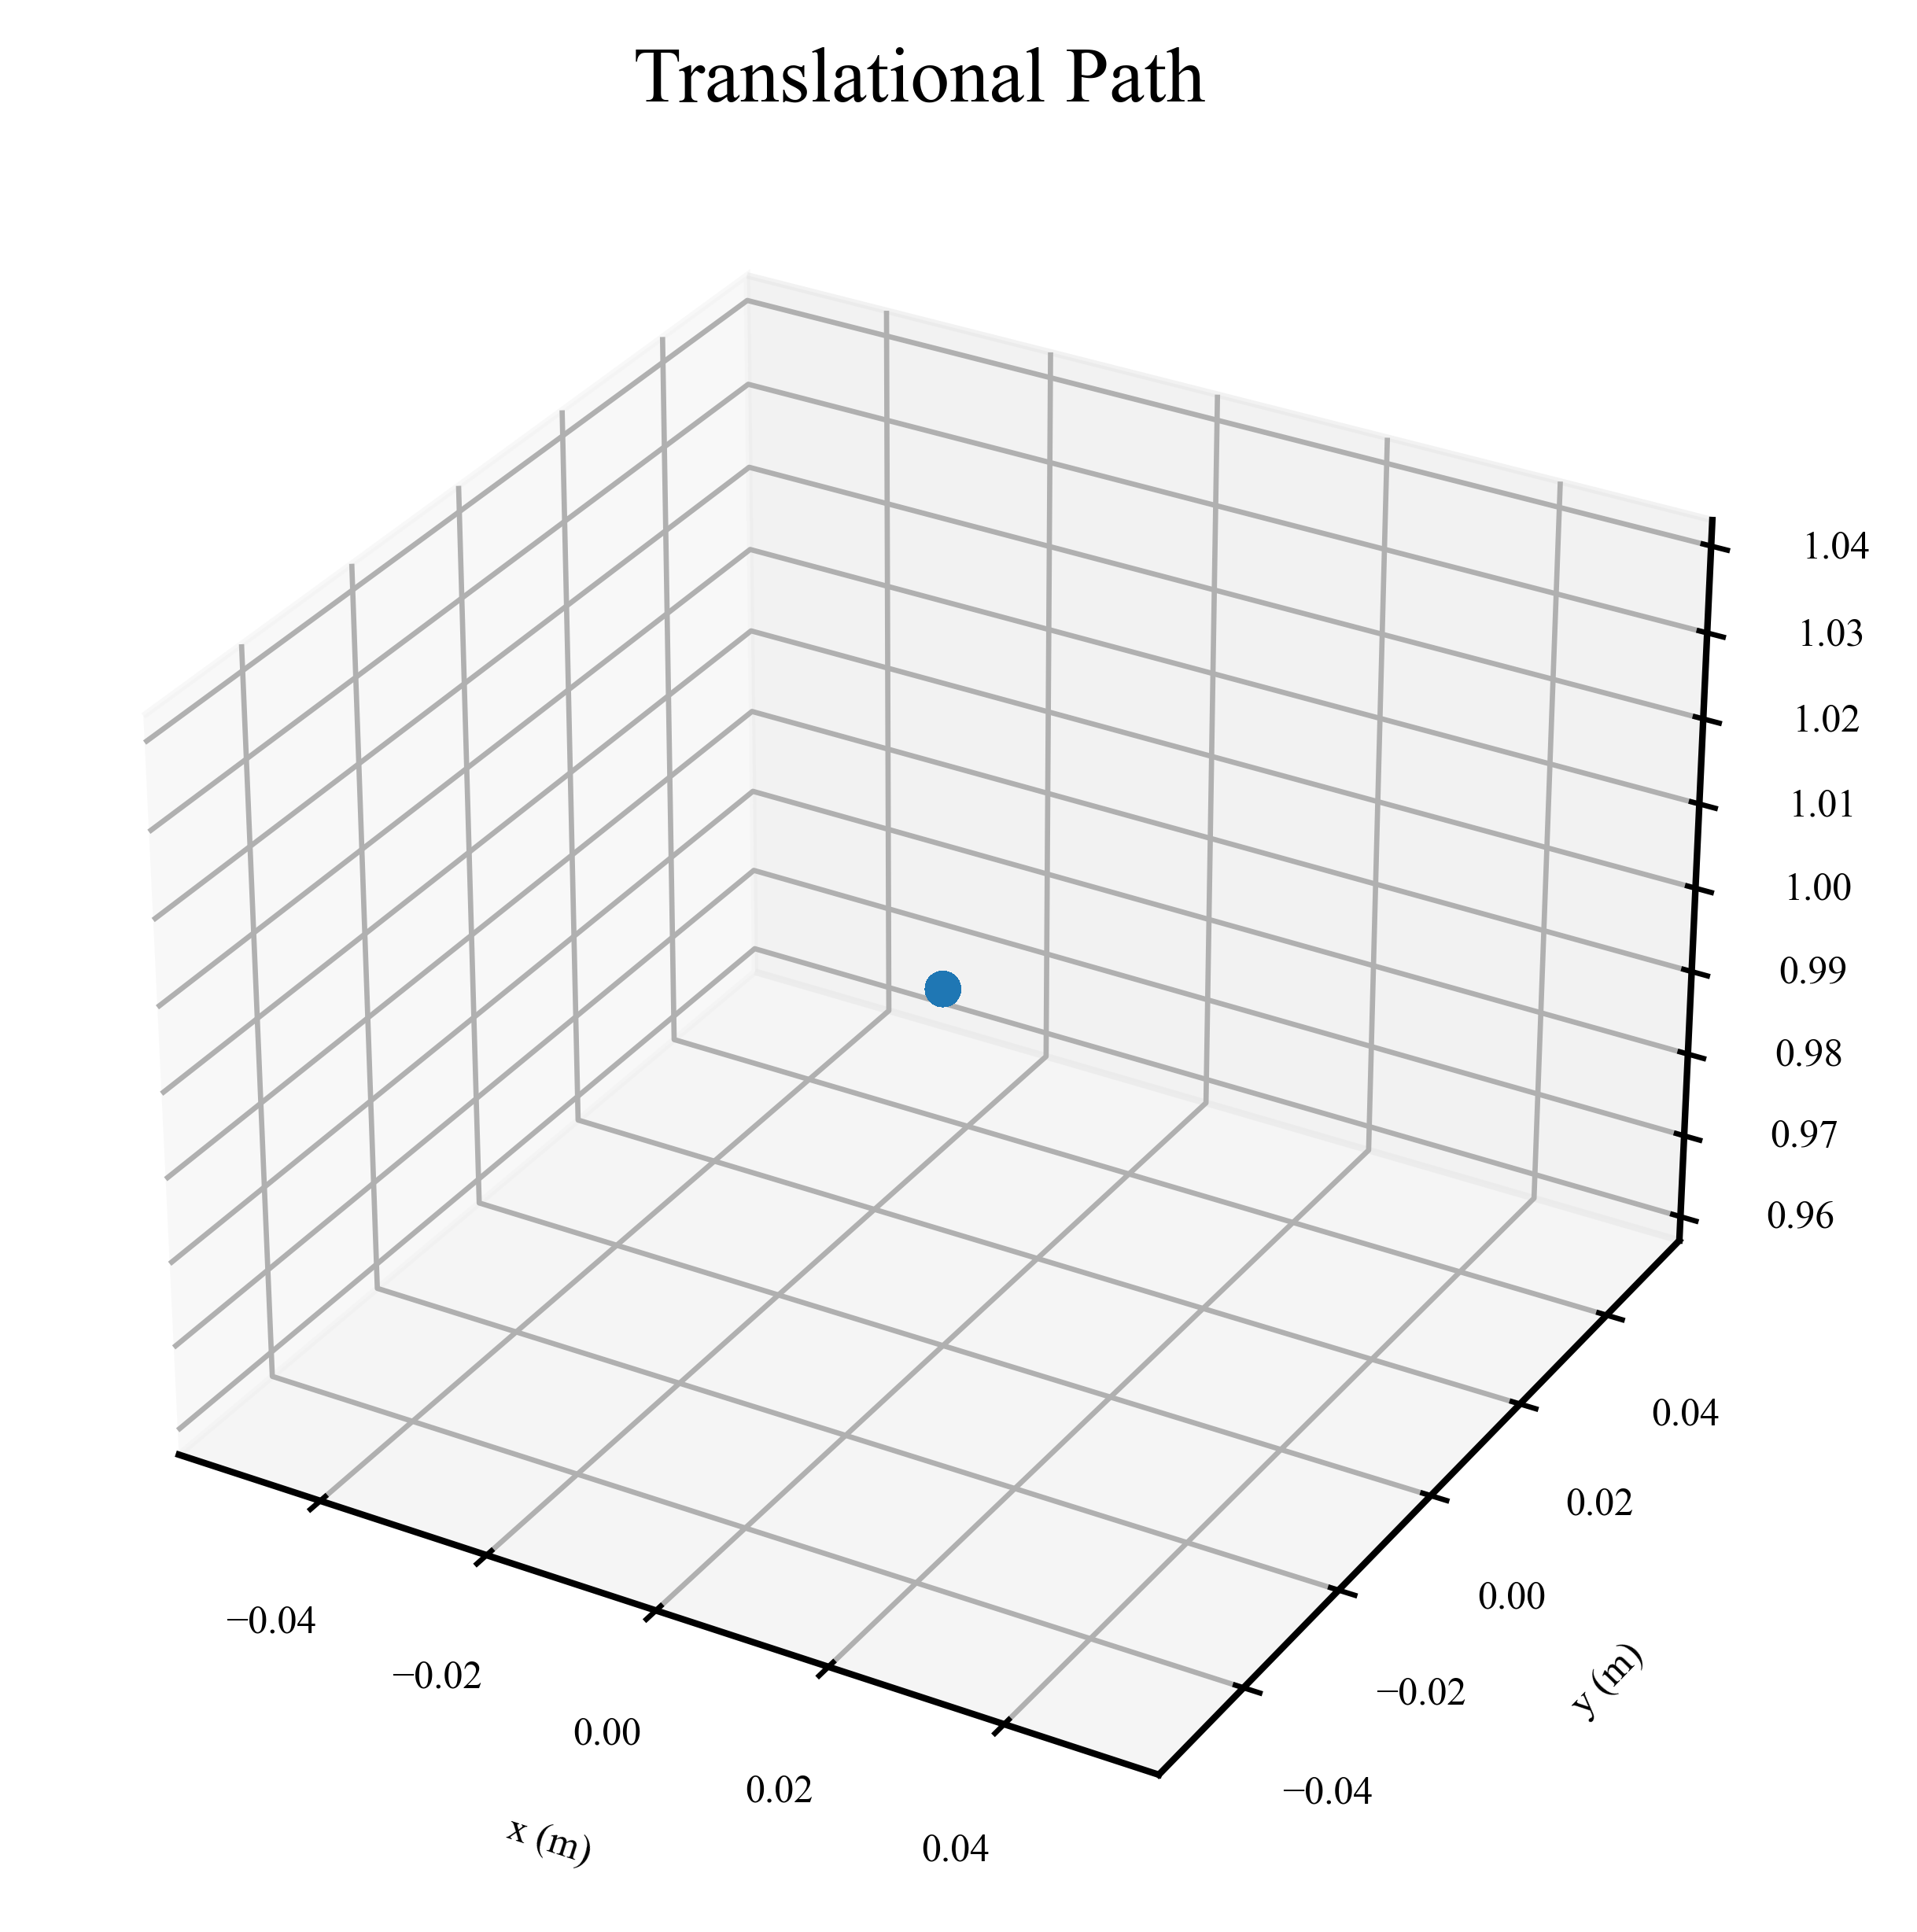

In [ ]:
### Plotting 3-D Path
fig = plt.figure()
pax = fig.add_subplot(111, projection='3d')

pax.scatter(sol.y[0], sol.y[1], sol.y[2])
pax.axis('equal')

pax.set_title('Translational Path')
pax.set_xlabel('x (m)')
pax.set_ylabel('y (m)')
pax.set_zlabel('z (m)')
fig.savefig(fname = 'hover_path', dpi = 200)
plt.show()

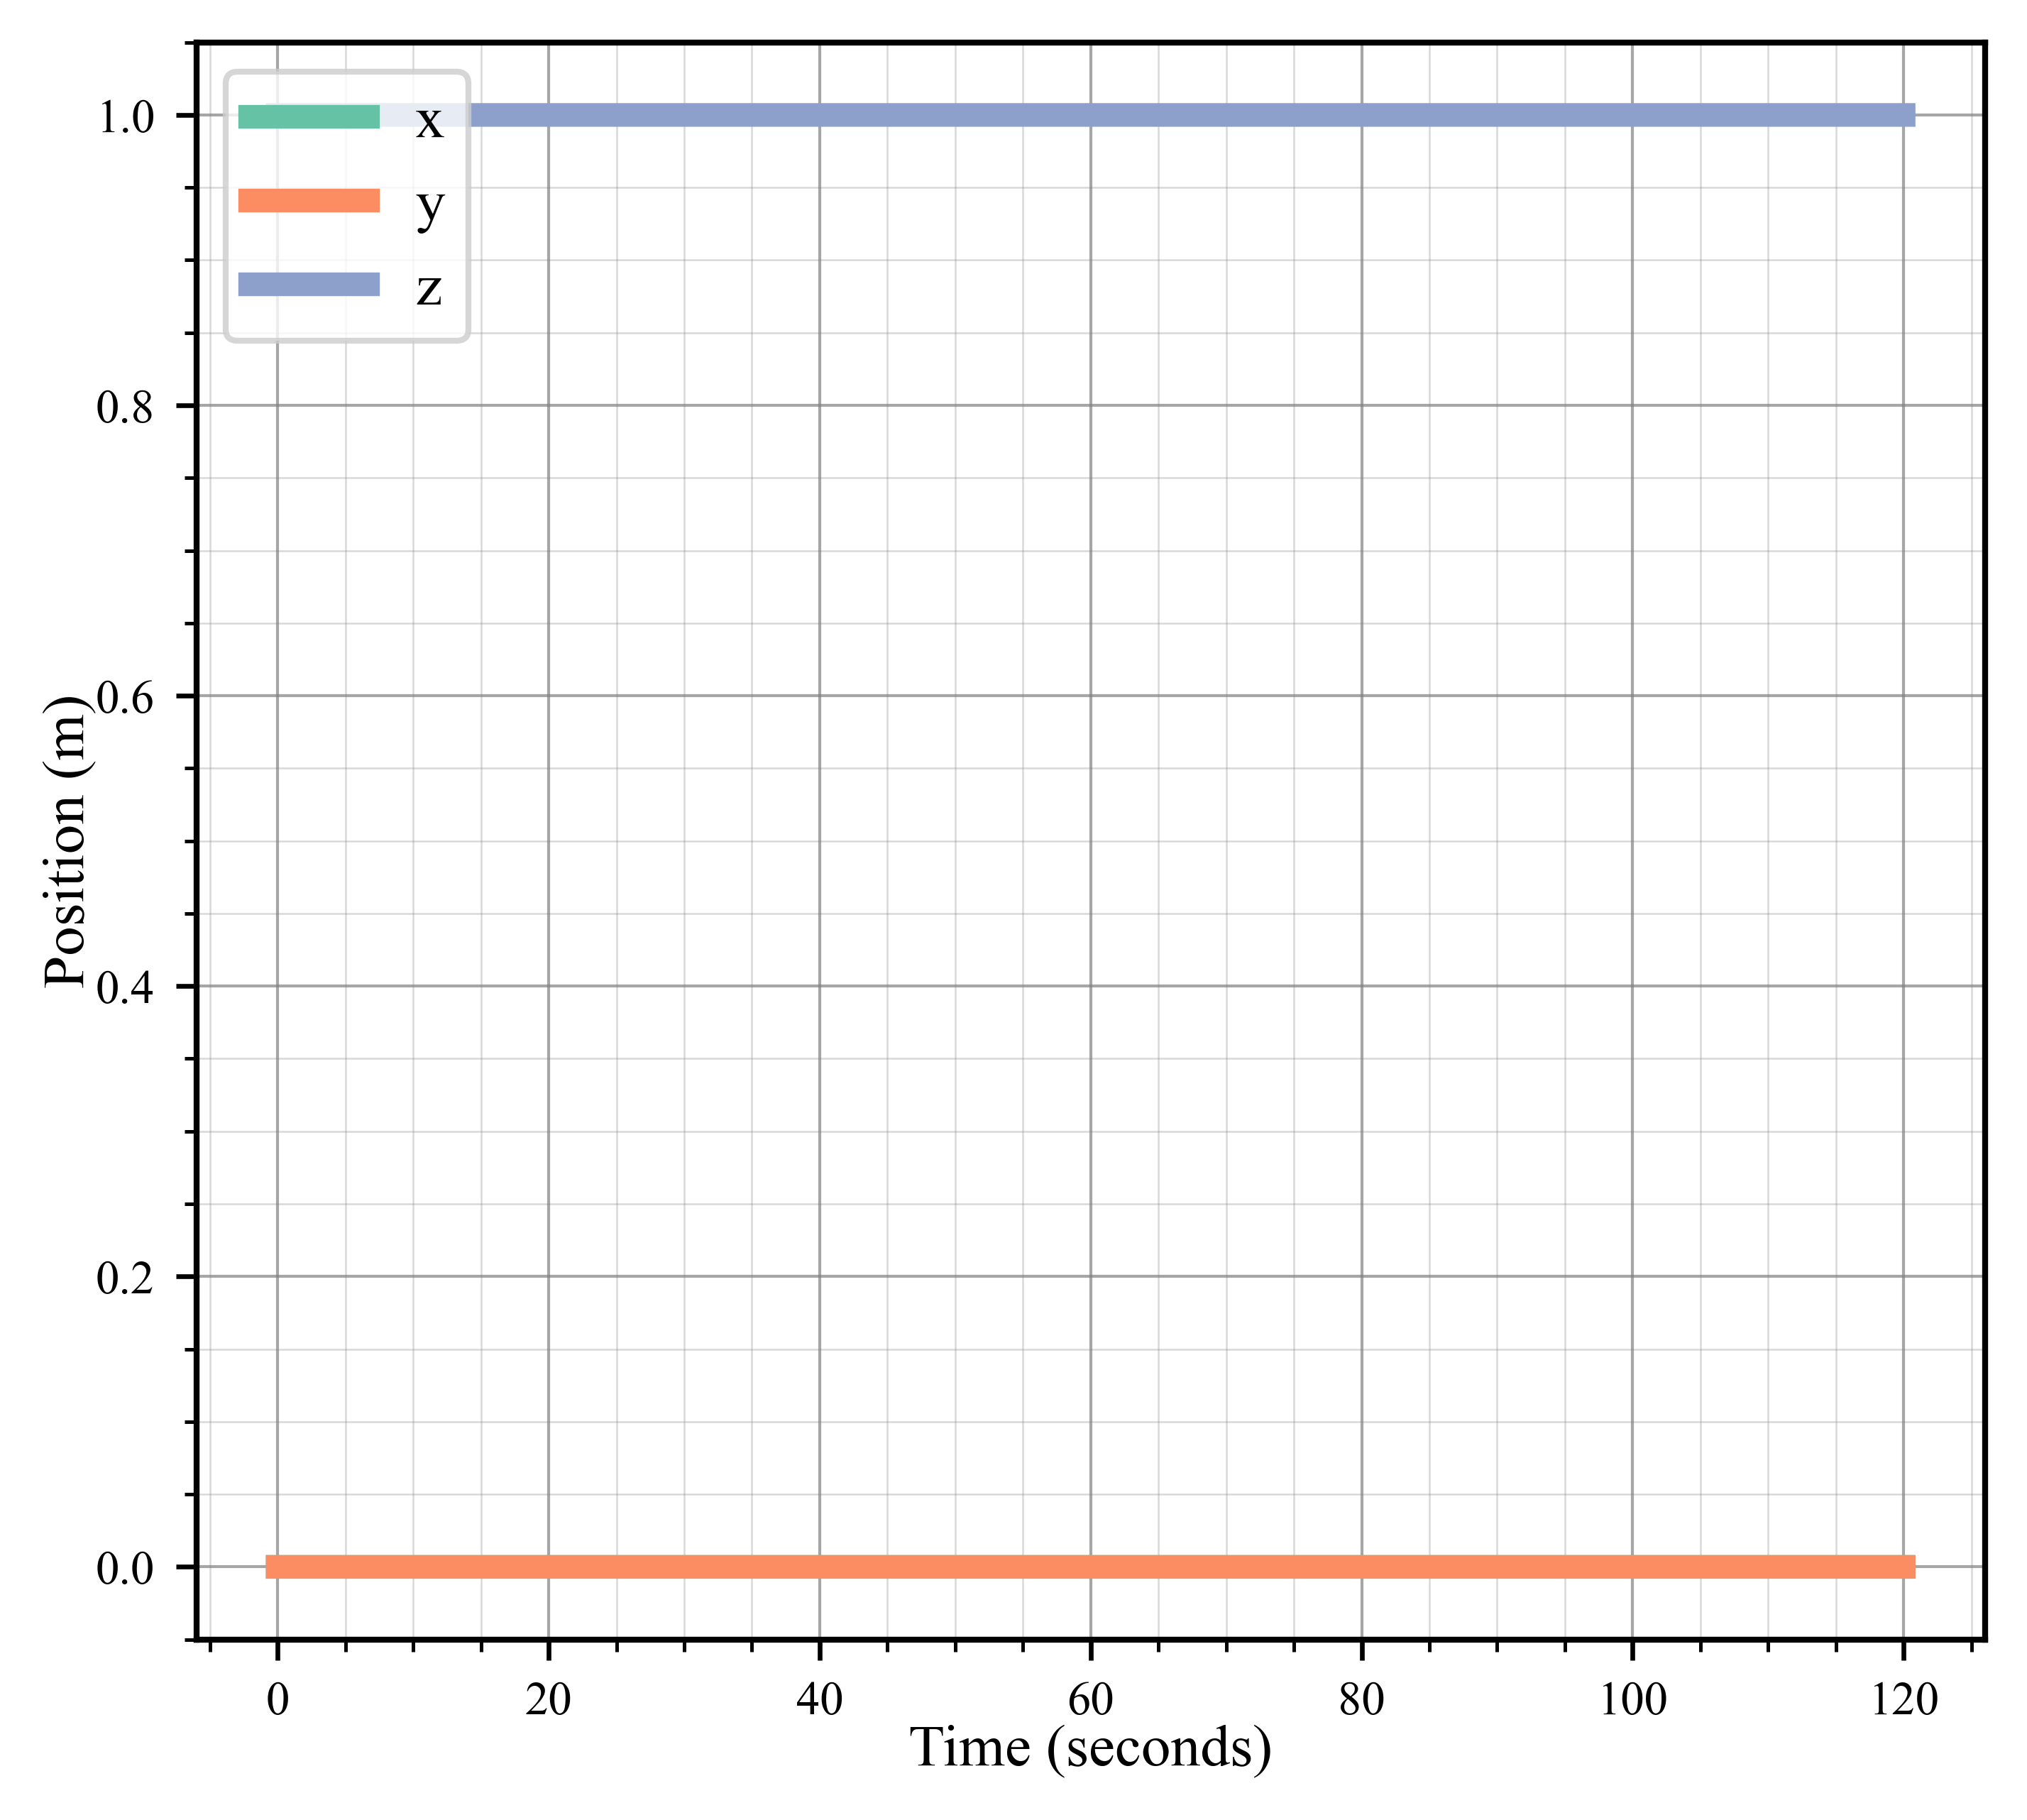

In [ ]:
solutions = np.array([sol.y[0], sol.y[1], sol.y[2]])
labels = ["x", "y", "z"]
y = (0.2, 0.05)
motion_plot(motion_list[0], sol.t, solutions, labels, colors, y)

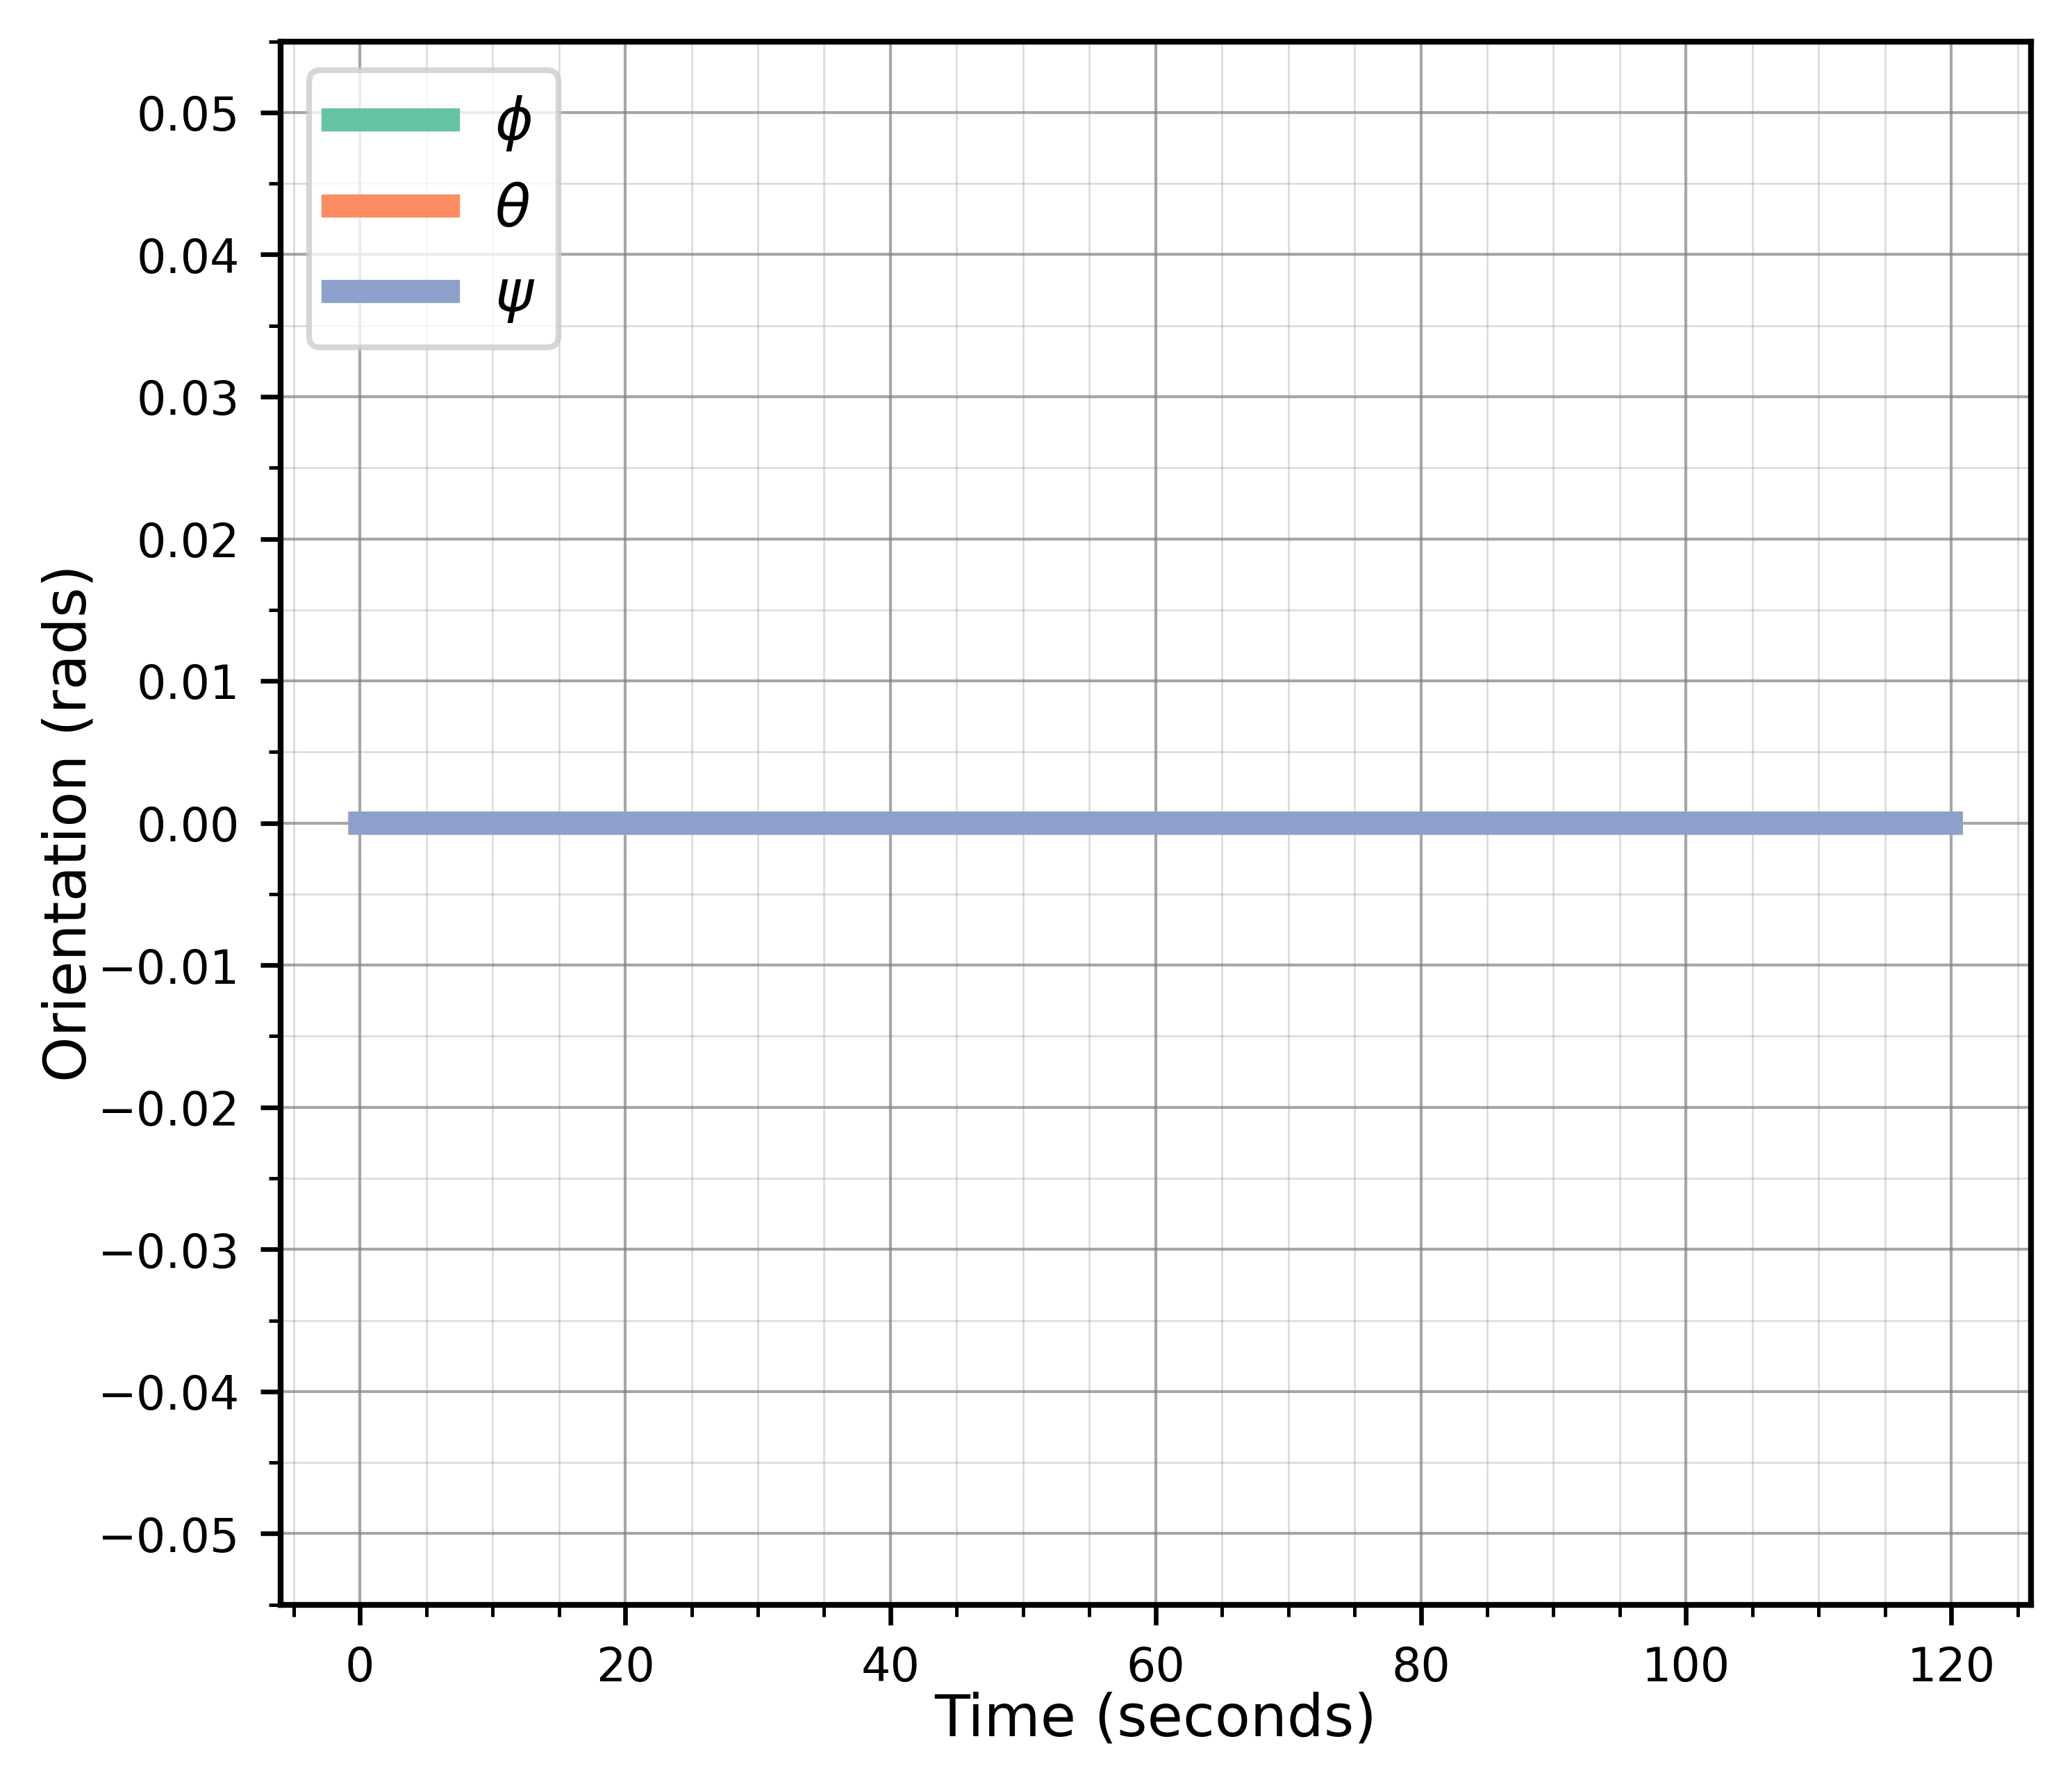

In [ ]:
solutions = np.array([sol.y[3], sol.y[4], sol.y[5]])
labels = ["$\phi$", "$\\theta$", "$\psi$"]
y = (0.01, 0.005)
motion_plot("Orientation (rads)", sol.t, solutions, labels, colors, y)

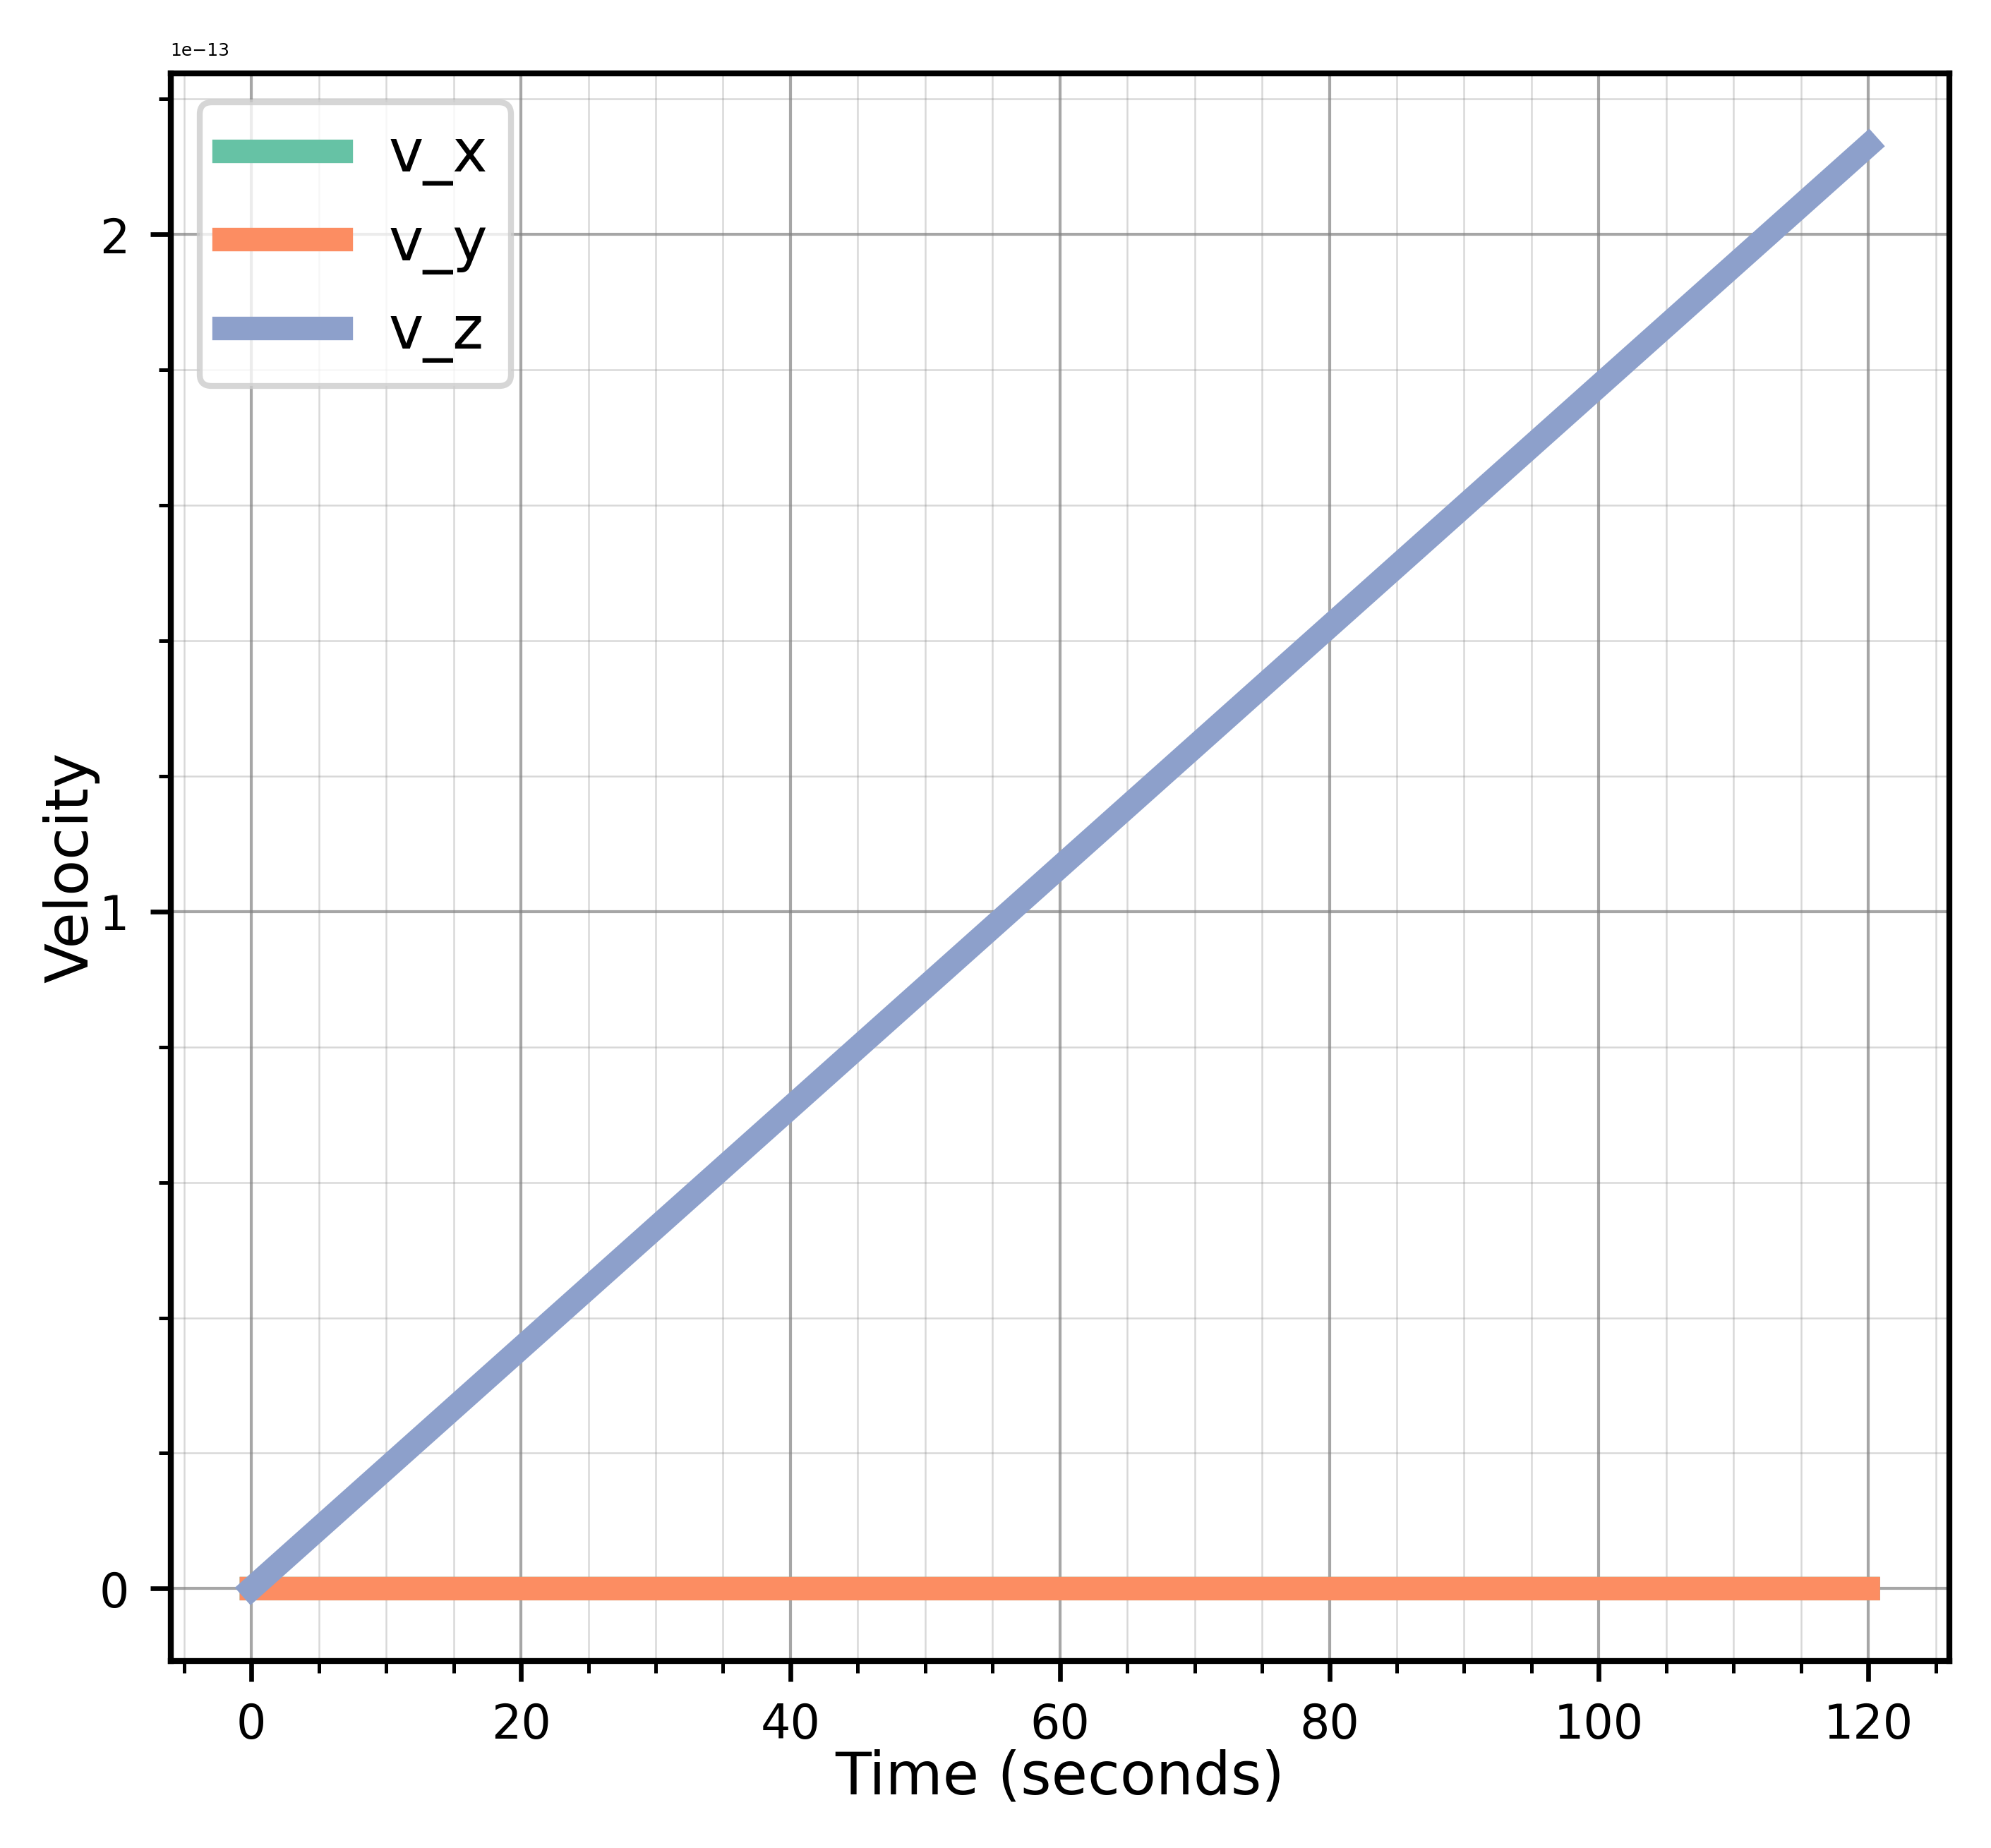

In [ ]:
solutions = np.array([sol.y[6], sol.y[7], sol.y[8]])
labels = ["v_x", "v_y", "v_z"]
y = (1e-13, 0.2e-13) ### v_z is basically 0
motion_plot(motion_list[2], sol.t, solutions, labels, colors, y)

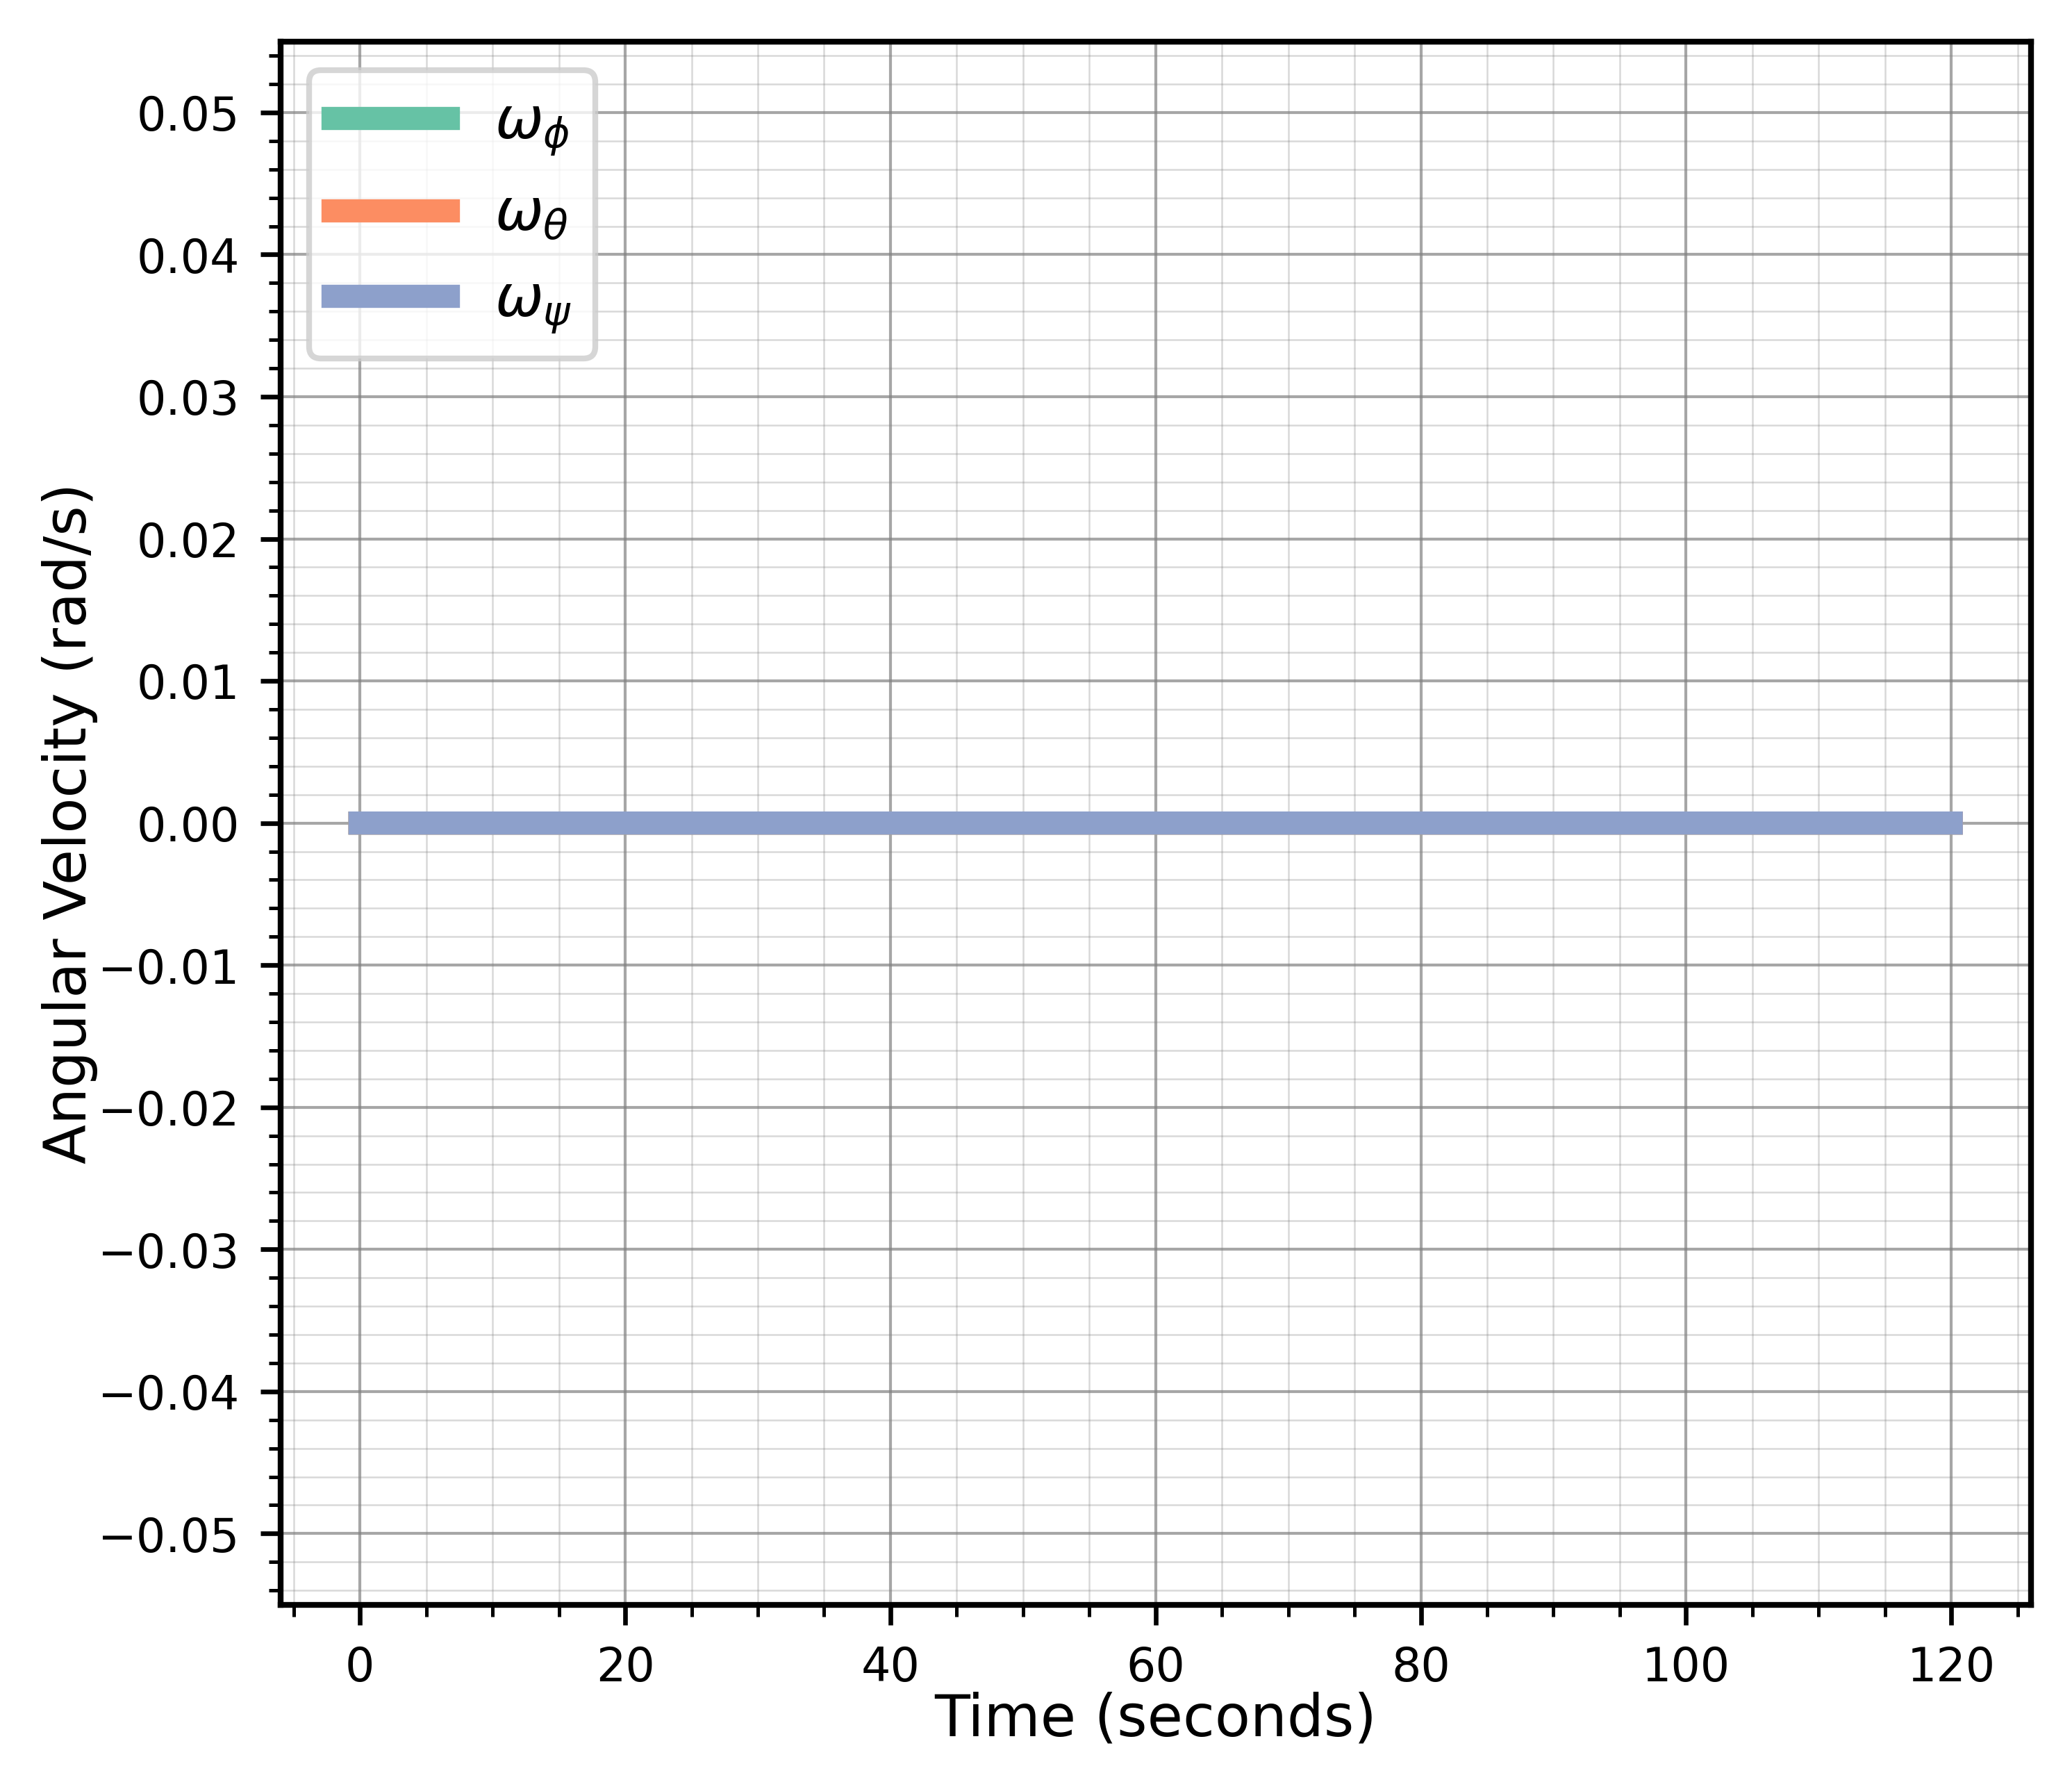

In [ ]:
solutions = np.array([sol.y[9], sol.y[10], sol.y[11]])
labels = ["$\omega_\phi$", "$\omega_\\theta$", "$\omega_\psi$"]
y = (0.01, 0.002)
motion_plot("Angular Velocity (rad/s)", sol.t, solutions, labels, colors, y)

## Circle

In [28]:
# Initial Parameters
t = (0, 60)
v_i = 0.5 # m/s
r = 2 # m
ang_vel = v_i/r
theta_max = -np.arctan(v_i**2/(g*r))
f_z = mass_total*g / np.cos(theta_max)

omega_x0 = v_i/r * np.sin(-theta_max)
omega_z0 = v_i/r * np.cos(-theta_max)
tau_y = (Ixx - Izz) * omega_x0 * omega_z0
omega_x0, omega_z0, tau_y, f_z

(0.0031852664033167055,
 0.24997970733229508,
 -1.4448152638489475e-05,
 20.053267737194357)

In [37]:
### Using the initial conditions from the previous cell, solve for rotor speeds
sigma1, sigma2, sigma3, sigma4 = symbols('sigma_1, sigma_2, sigma_3, sigma_4')
taux = Eq(length_rz * k_F * (-sigma2**2 + sigma4**2), 0)
tauy = Eq(length_rz * k_F * (-sigma1**2 + sigma3**2), tau_y)
tauz = Eq(length_rz * k_M * (sigma1**2 - sigma2**2 + sigma3**2 - sigma4**2), 0)
fz = Eq(k_F * (sigma1**2 + sigma2**2 + sigma3**2 + sigma4**2), f_z)

soln = solve([taux, tauy, tauz, fz], (sigma1, sigma2, sigma3, sigma4))
soln

[(-28074.0089358063, -28073.6044044306, -28073.1998672257, -28073.6044044306),
 (-28074.0089358063, -28073.6044044306, -28073.1998672257, 28073.6044044306),
 (-28074.0089358063, -28073.6044044306, 28073.1998672257, -28073.6044044306),
 (-28074.0089358063, -28073.6044044306, 28073.1998672257, 28073.6044044306),
 (-28074.0089358063, 28073.6044044306, -28073.1998672257, -28073.6044044306),
 (-28074.0089358063, 28073.6044044306, -28073.1998672257, 28073.6044044306),
 (-28074.0089358063, 28073.6044044306, 28073.1998672257, -28073.6044044306),
 (-28074.0089358063, 28073.6044044306, 28073.1998672257, 28073.6044044306),
 (28074.0089358063, -28073.6044044306, -28073.1998672257, -28073.6044044306),
 (28074.0089358063, -28073.6044044306, -28073.1998672257, 28073.6044044306),
 (28074.0089358063, -28073.6044044306, 28073.1998672257, -28073.6044044306),
 (28074.0089358063, -28073.6044044306, 28073.1998672257, 28073.6044044306),
 (28074.0089358063, 28073.6044044306, -28073.1998672257, -28073.60440443

In [43]:
### Use these rotor speeds to get your new inputs
sigma1 = 28074.0089358063
sigma2 = 28073.6044044306
sigma3 = 28073.1998672257
sigma4 = 28073.6044044306
#28072.46500465776

f_req = u(sigma1, sigma2, sigma3, sigma4)
f_req

print(sigma1/28072.46500465776  *  5919.37314)

5919.6986940462575


In [31]:
### Initial Conditions: State, Input, and Parameters
x0 = np.array([2, 0, 1, 0, theta_max, 0, 0, v_i, 0, omega_x0, 0, omega_z0])
u_val = u(sigma1, sigma2, sigma3, sigma4)
params = np.array([mass_total, Ixx, Iyy, Izz])

### Arguments for solve_ivp
ar = (u_val, params)
t = (0, 120)

sol = solve_ivp(quad_EOM, t, x0, max_step = 0.1, args = ar)
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  4.066e-03 ...  1.199e+02  1.200e+02]
        y: [[ 2.000e+00  2.000e+00 ...  3.961e-02  4.767e-02]
            [ 0.000e+00  2.033e-03 ... -2.759e-01 -3.024e-01]
            ...
            [ 0.000e+00 -1.539e-16 ... -5.562e-09 -5.589e-09]
            [ 2.500e-01  2.500e-01 ...  2.500e-01  2.500e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 7214
     njev: 0
      nlu: 0

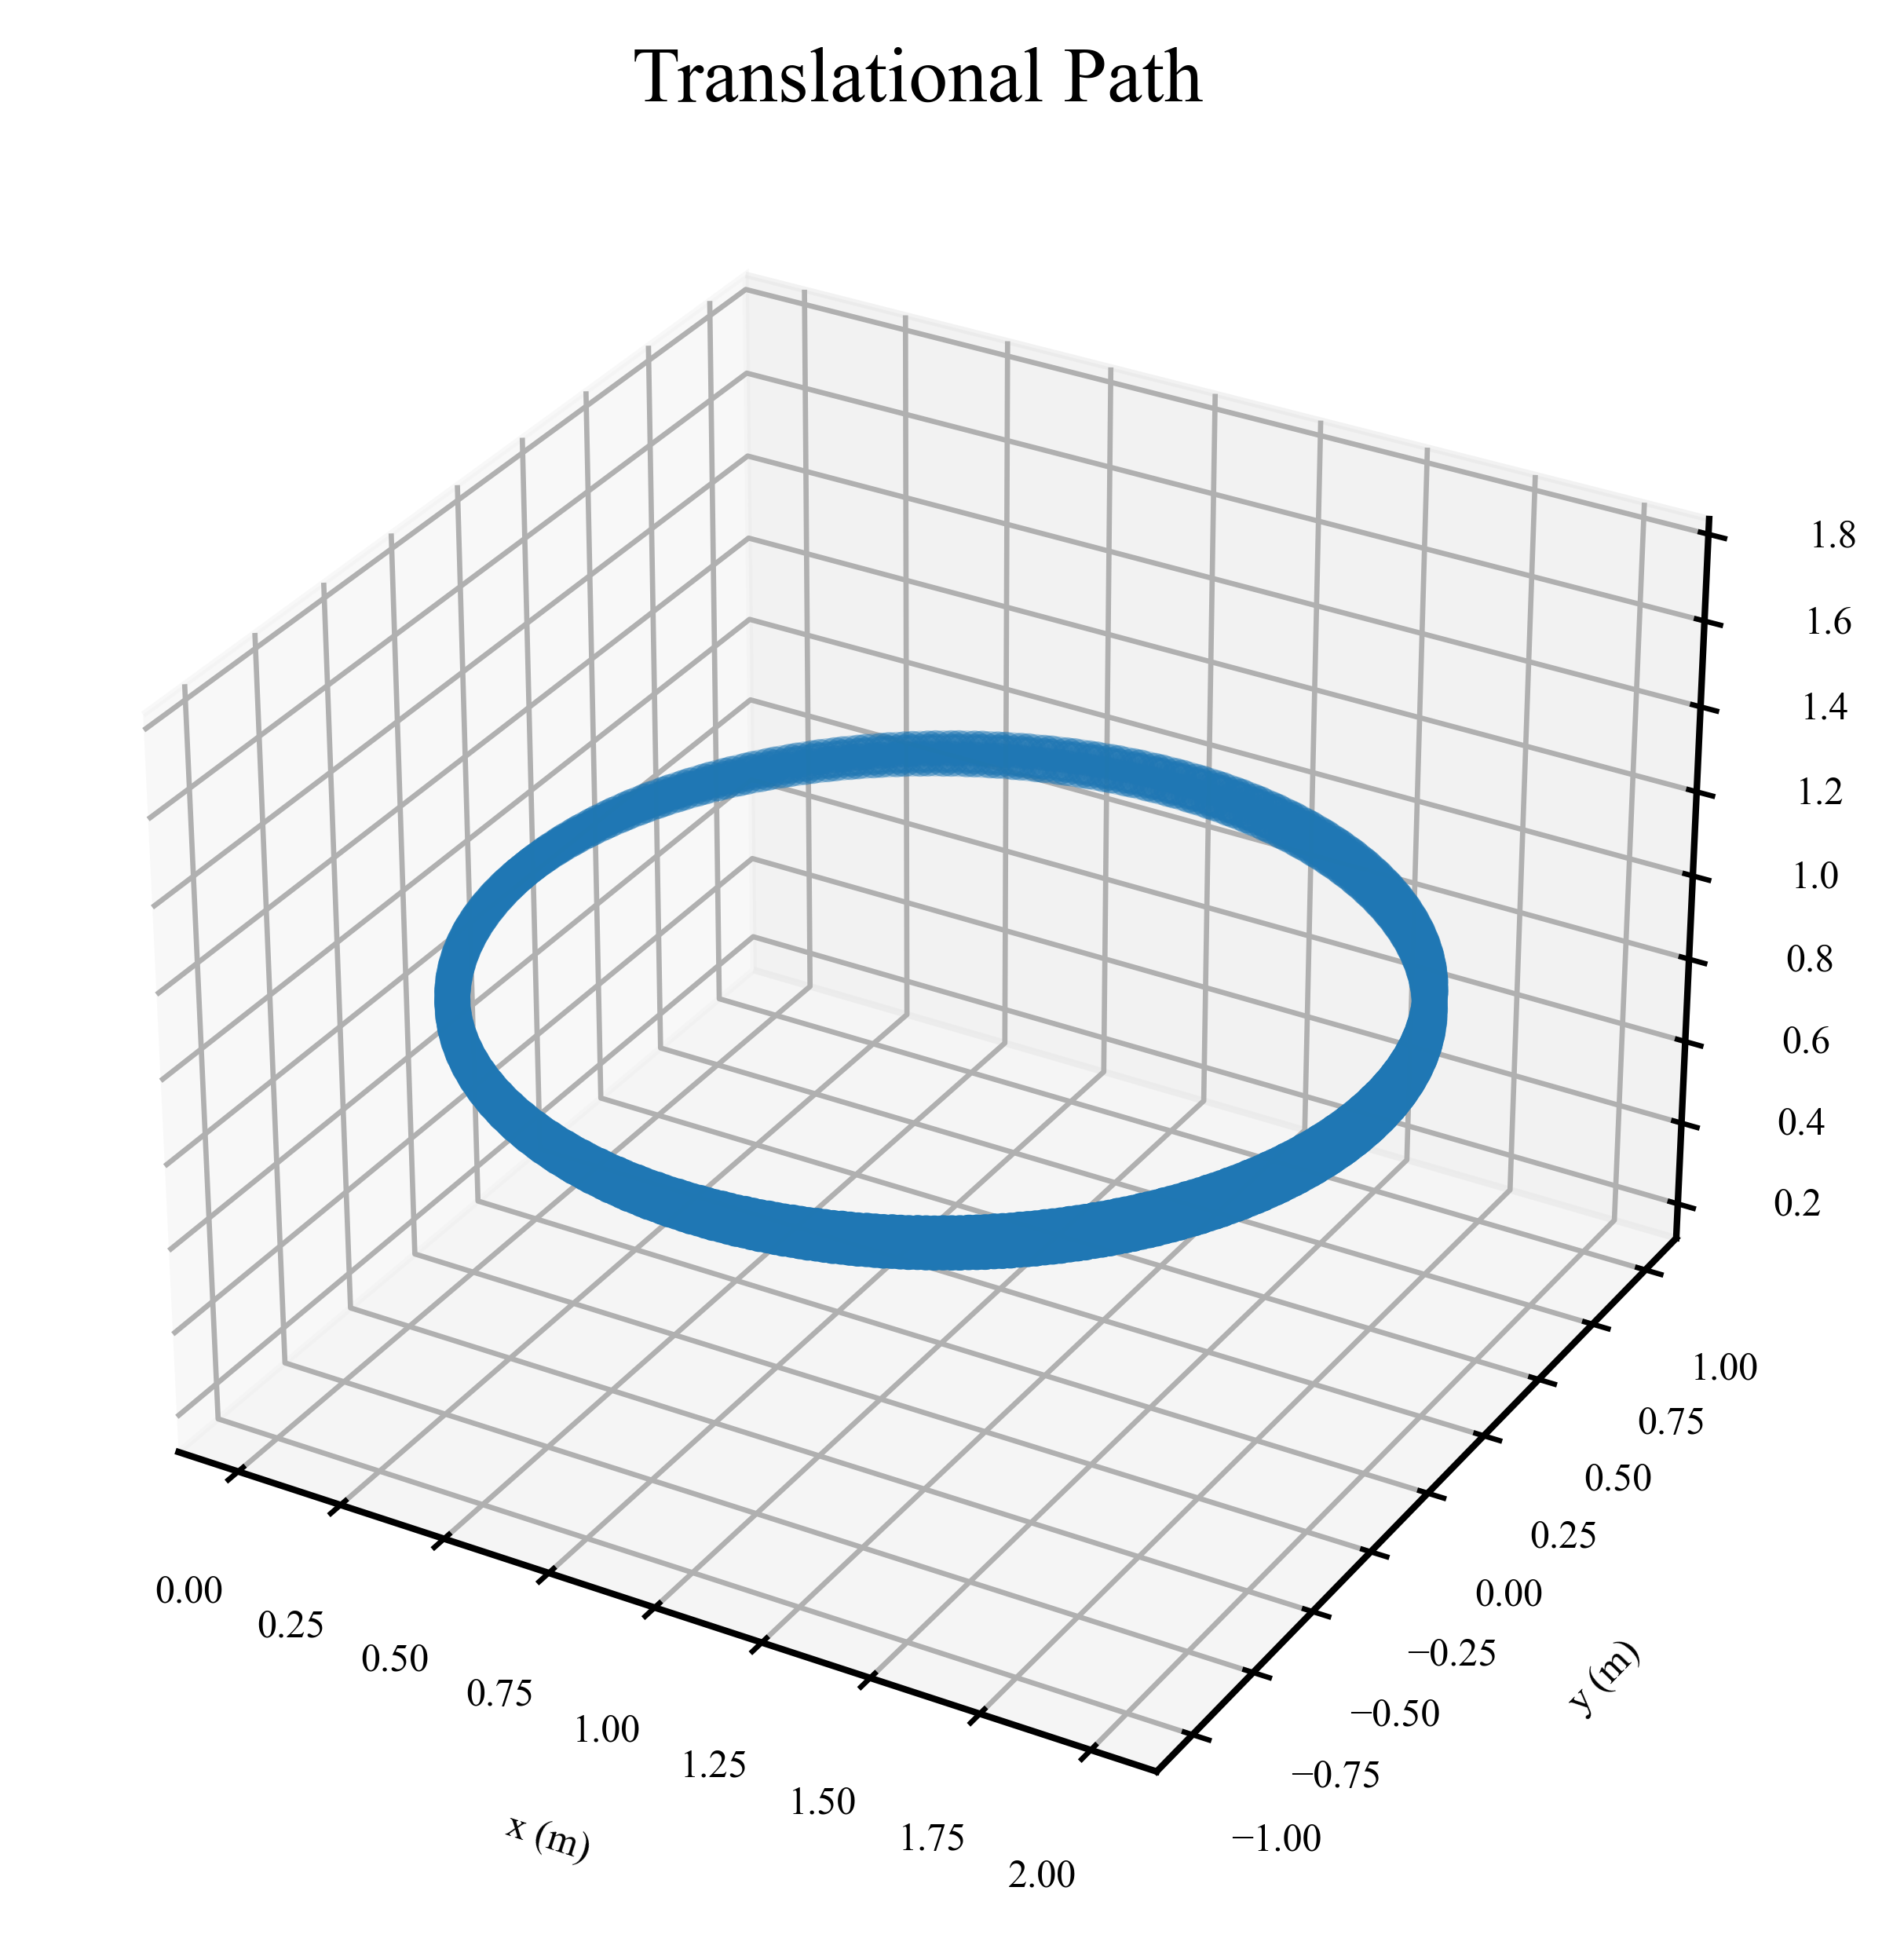

In [ ]:
fig = plt.figure()
pax = fig.add_subplot(111, projection='3d')

pax.scatter(sol.y[0], sol.y[1], sol.y[2])
pax.axis('equal')

pax.set_title('Translational Path')
pax.set_xlabel('x (m)')
pax.set_ylabel('y (m)')
pax.set_zlabel('z (m)')
fig.savefig(fname = 'hover_path', dpi = 200)
plt.show()

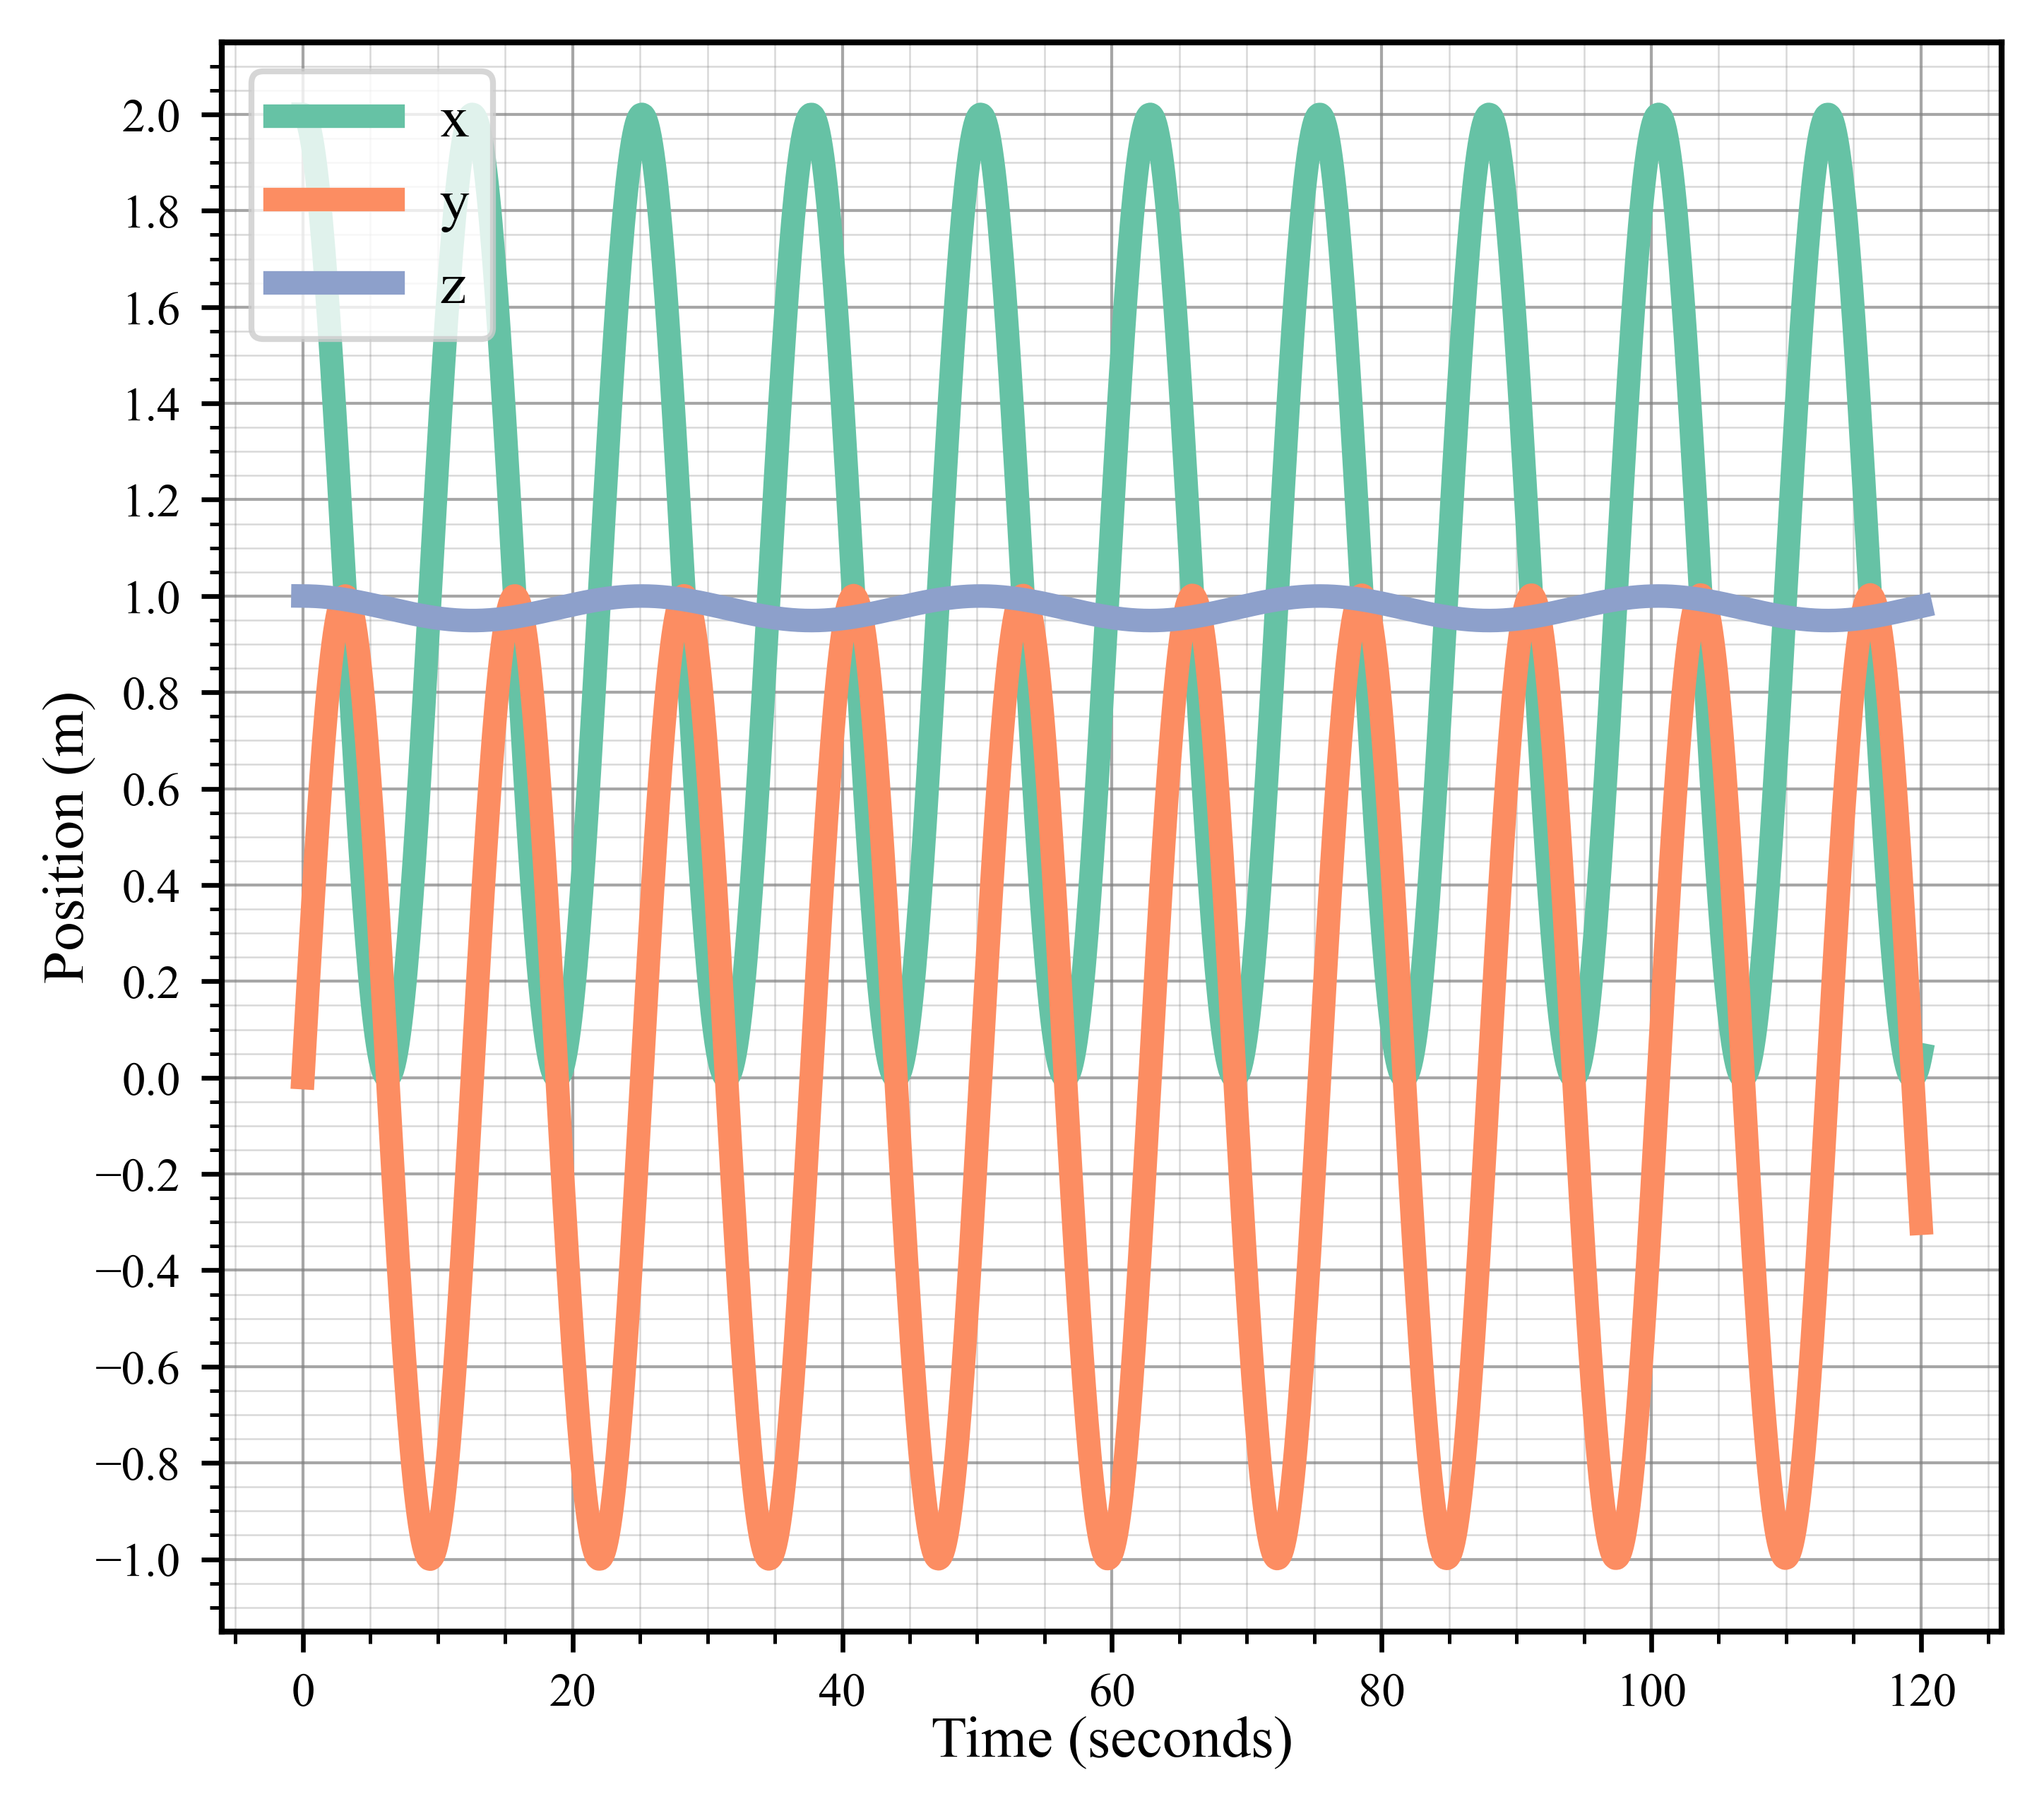

In [ ]:
solutions = np.array([sol.y[0], sol.y[1], sol.y[2]])
labels = ["x", "y", "z"]
y = (0.2, 0.05)
motion_plot(motion_list[0], sol.t, solutions, labels, colors, y)

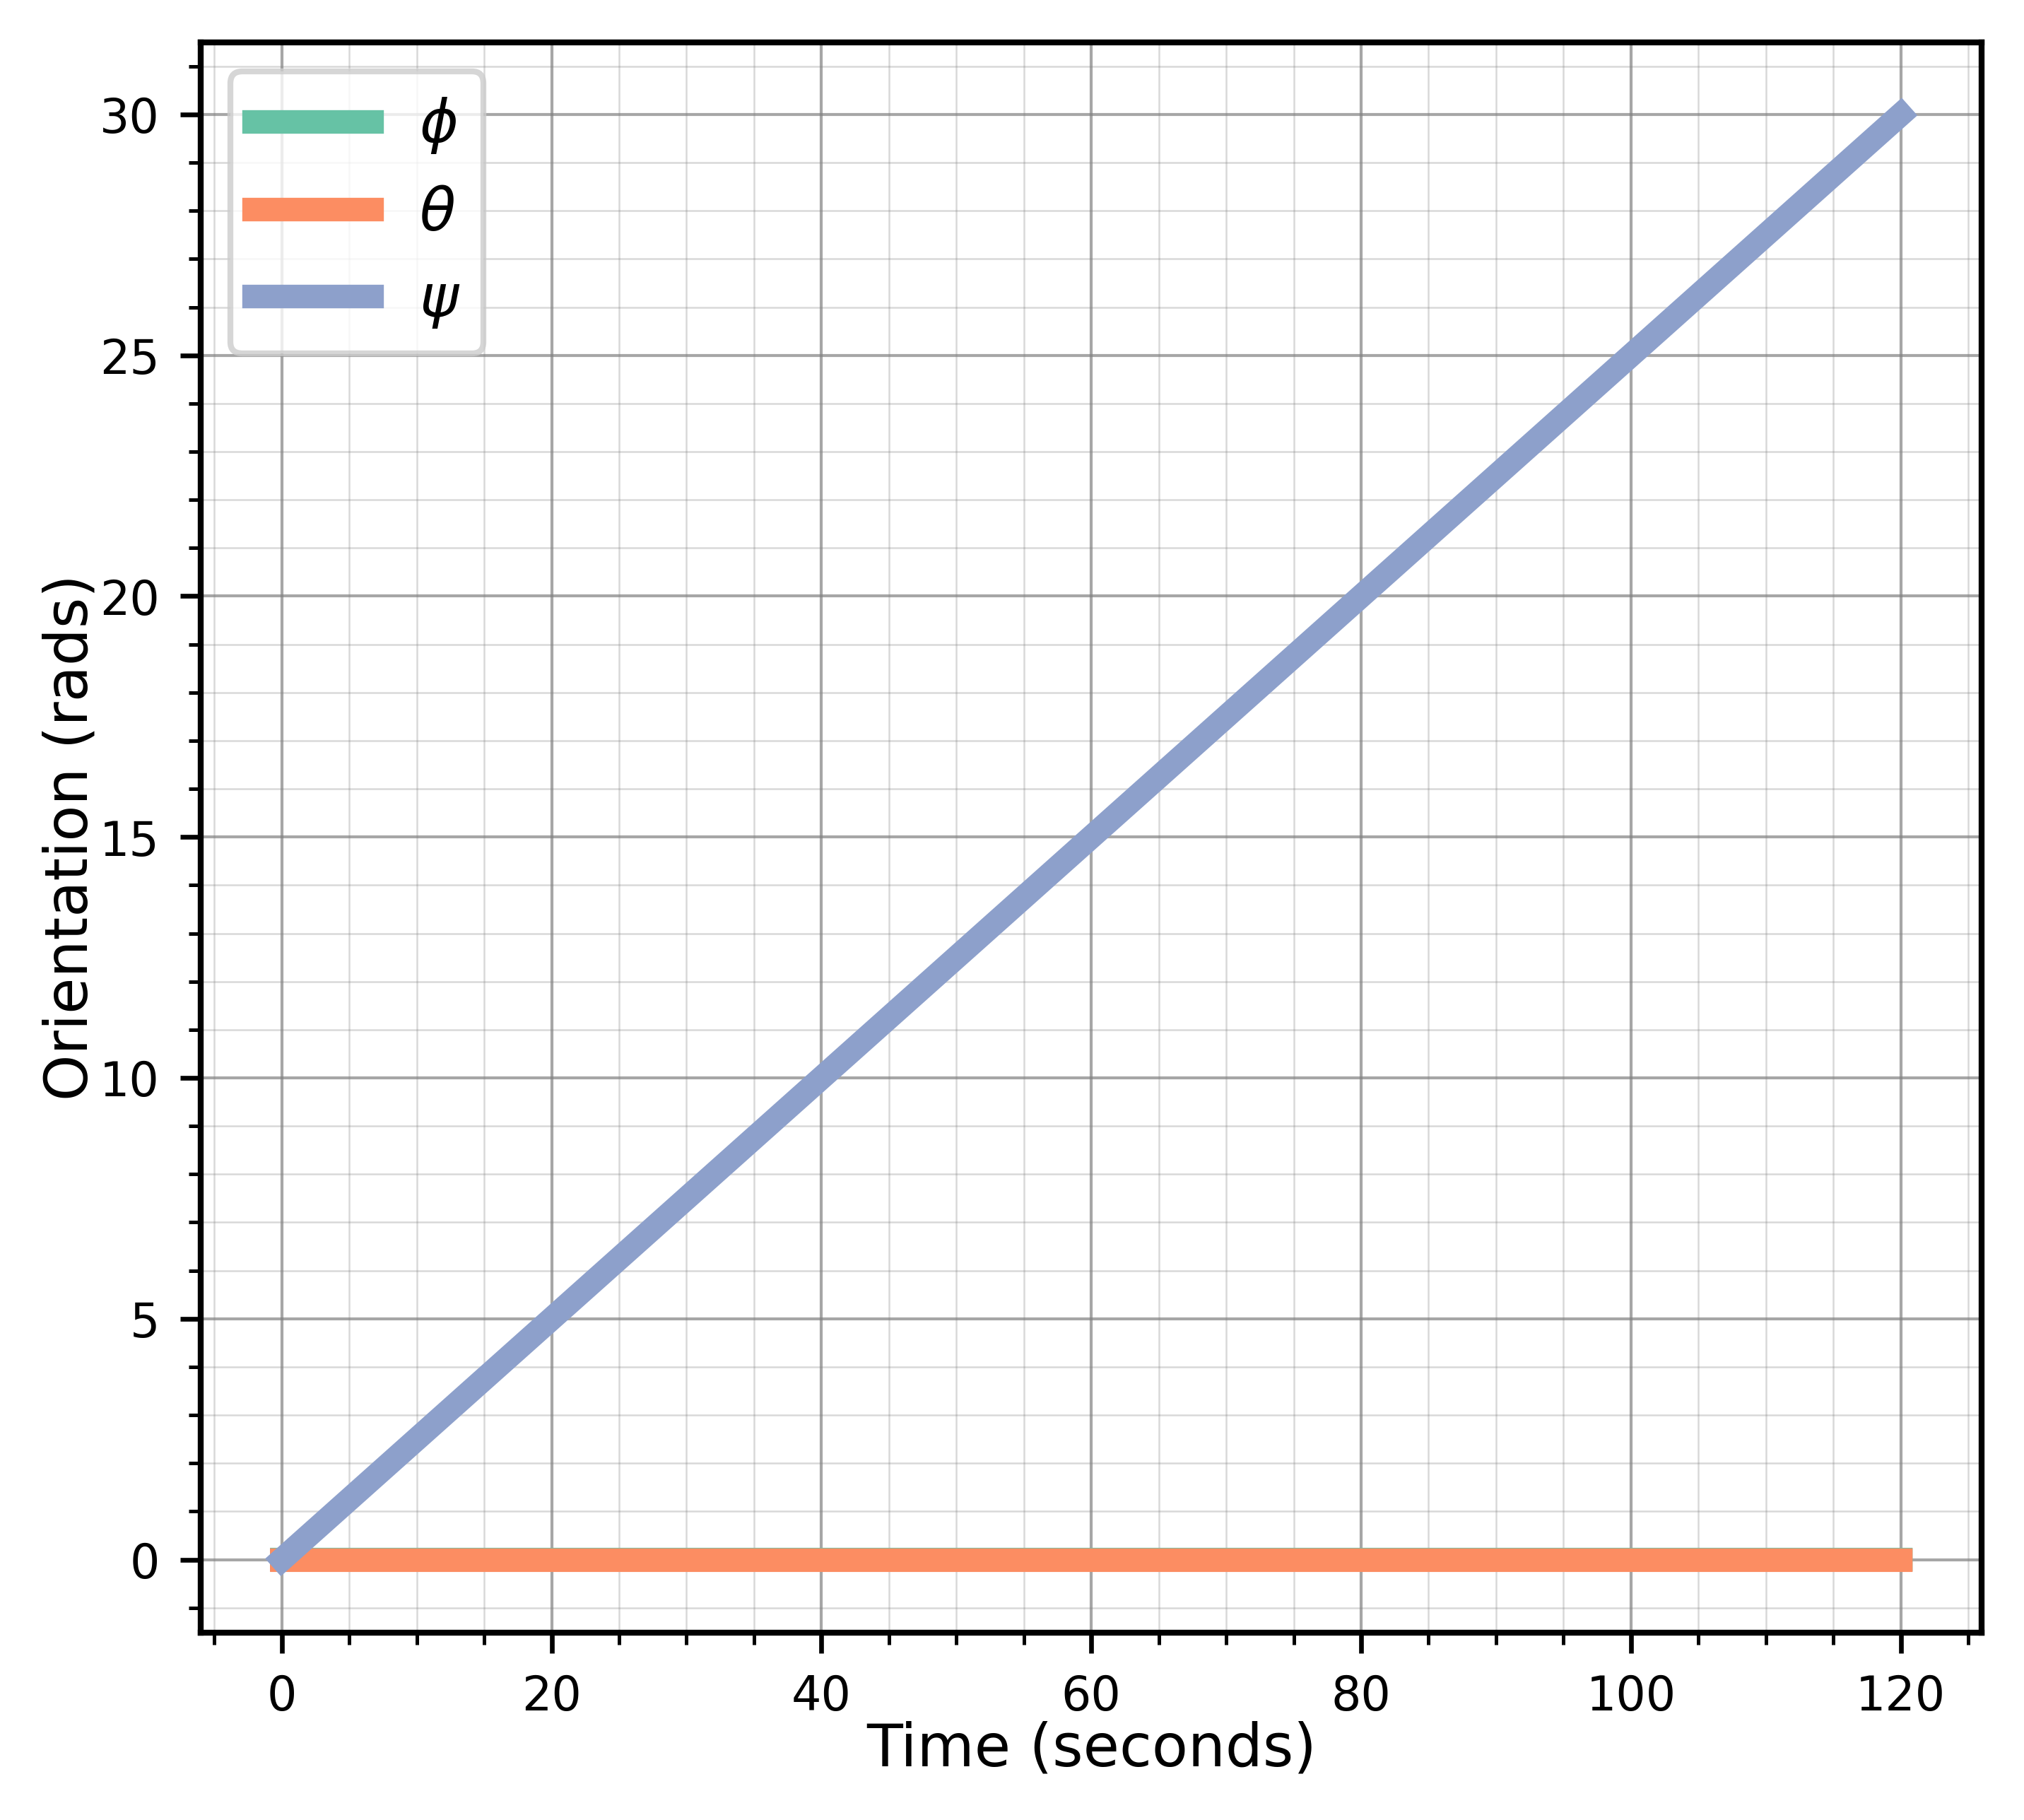

In [32]:
solutions = np.array([sol.y[3], sol.y[4], sol.y[5]])
labels = ["$\phi$", r"$\theta$", "$\psi$"]
y = (5, 1)
motion_plot("Orientation (rads)", sol.t, solutions, labels, colors, y)

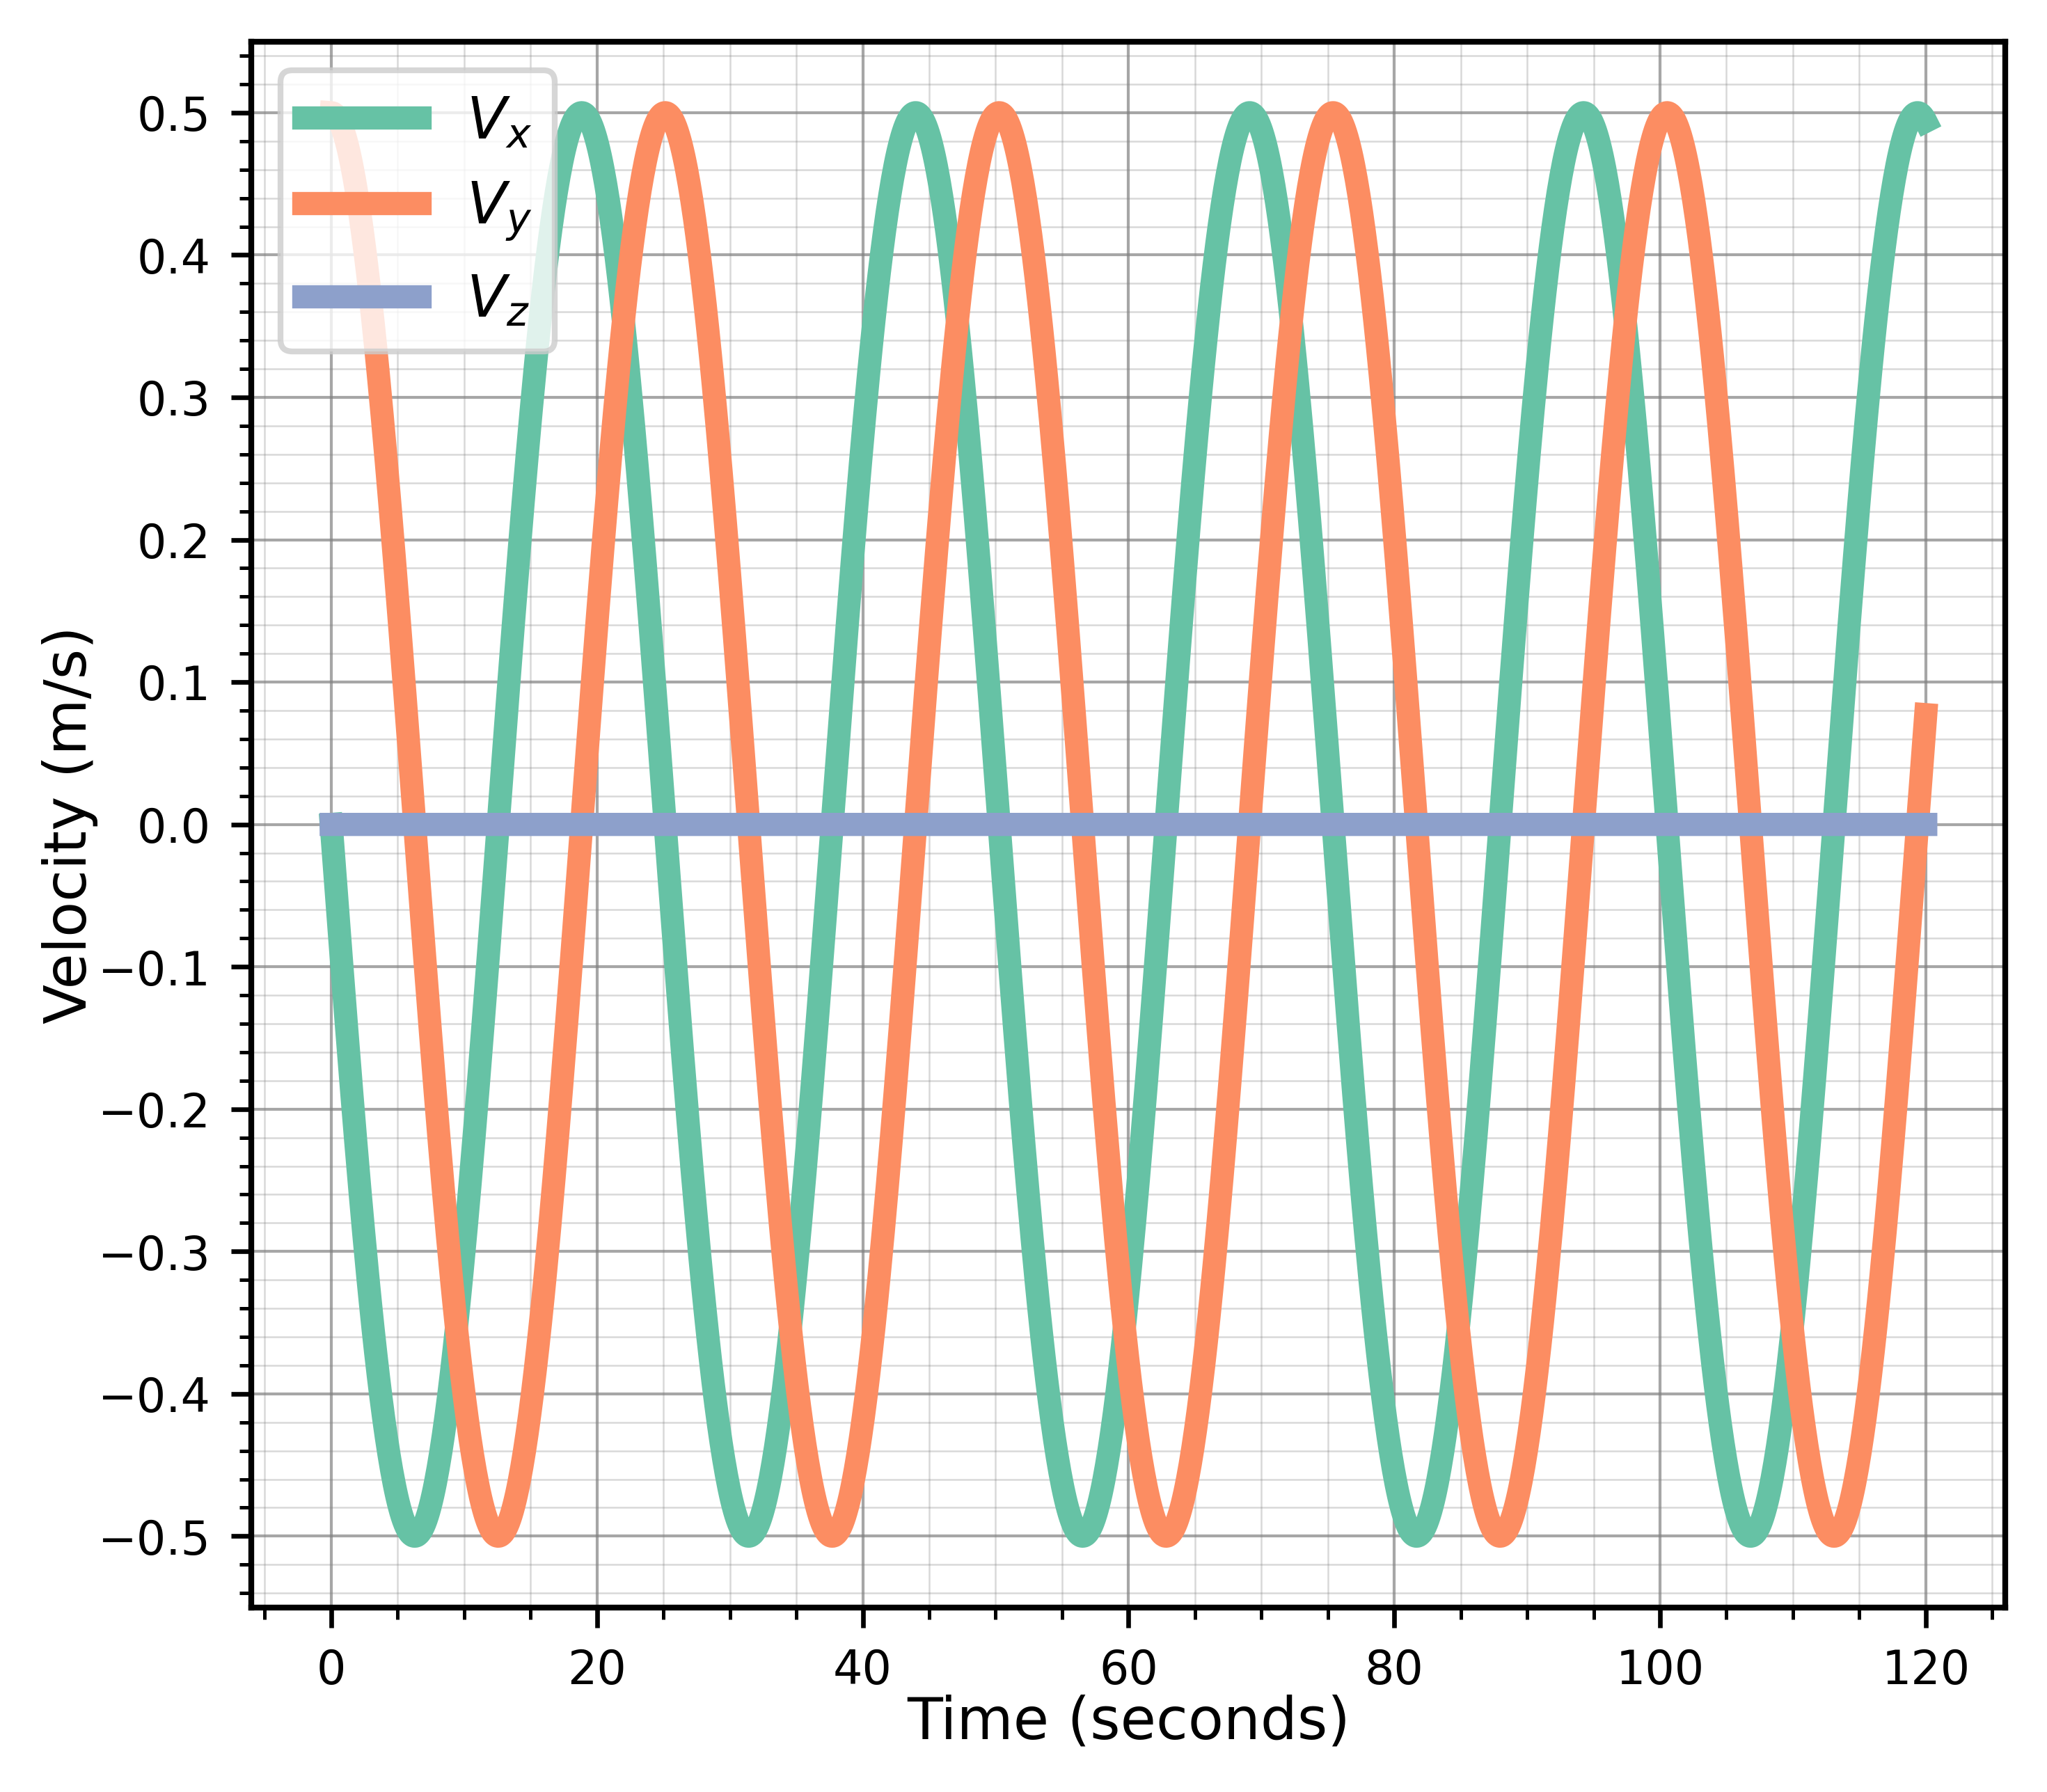

In [34]:
solutions = np.array([sol.y[6], sol.y[7], sol.y[8]])
labels = ["$V_x$", "$V_y$", "$V_z$"]
y = (0.1, 0.02) ### v_z is basically 0
motion_plot("Velocity (m/s)", sol.t, solutions, labels, colors, y)

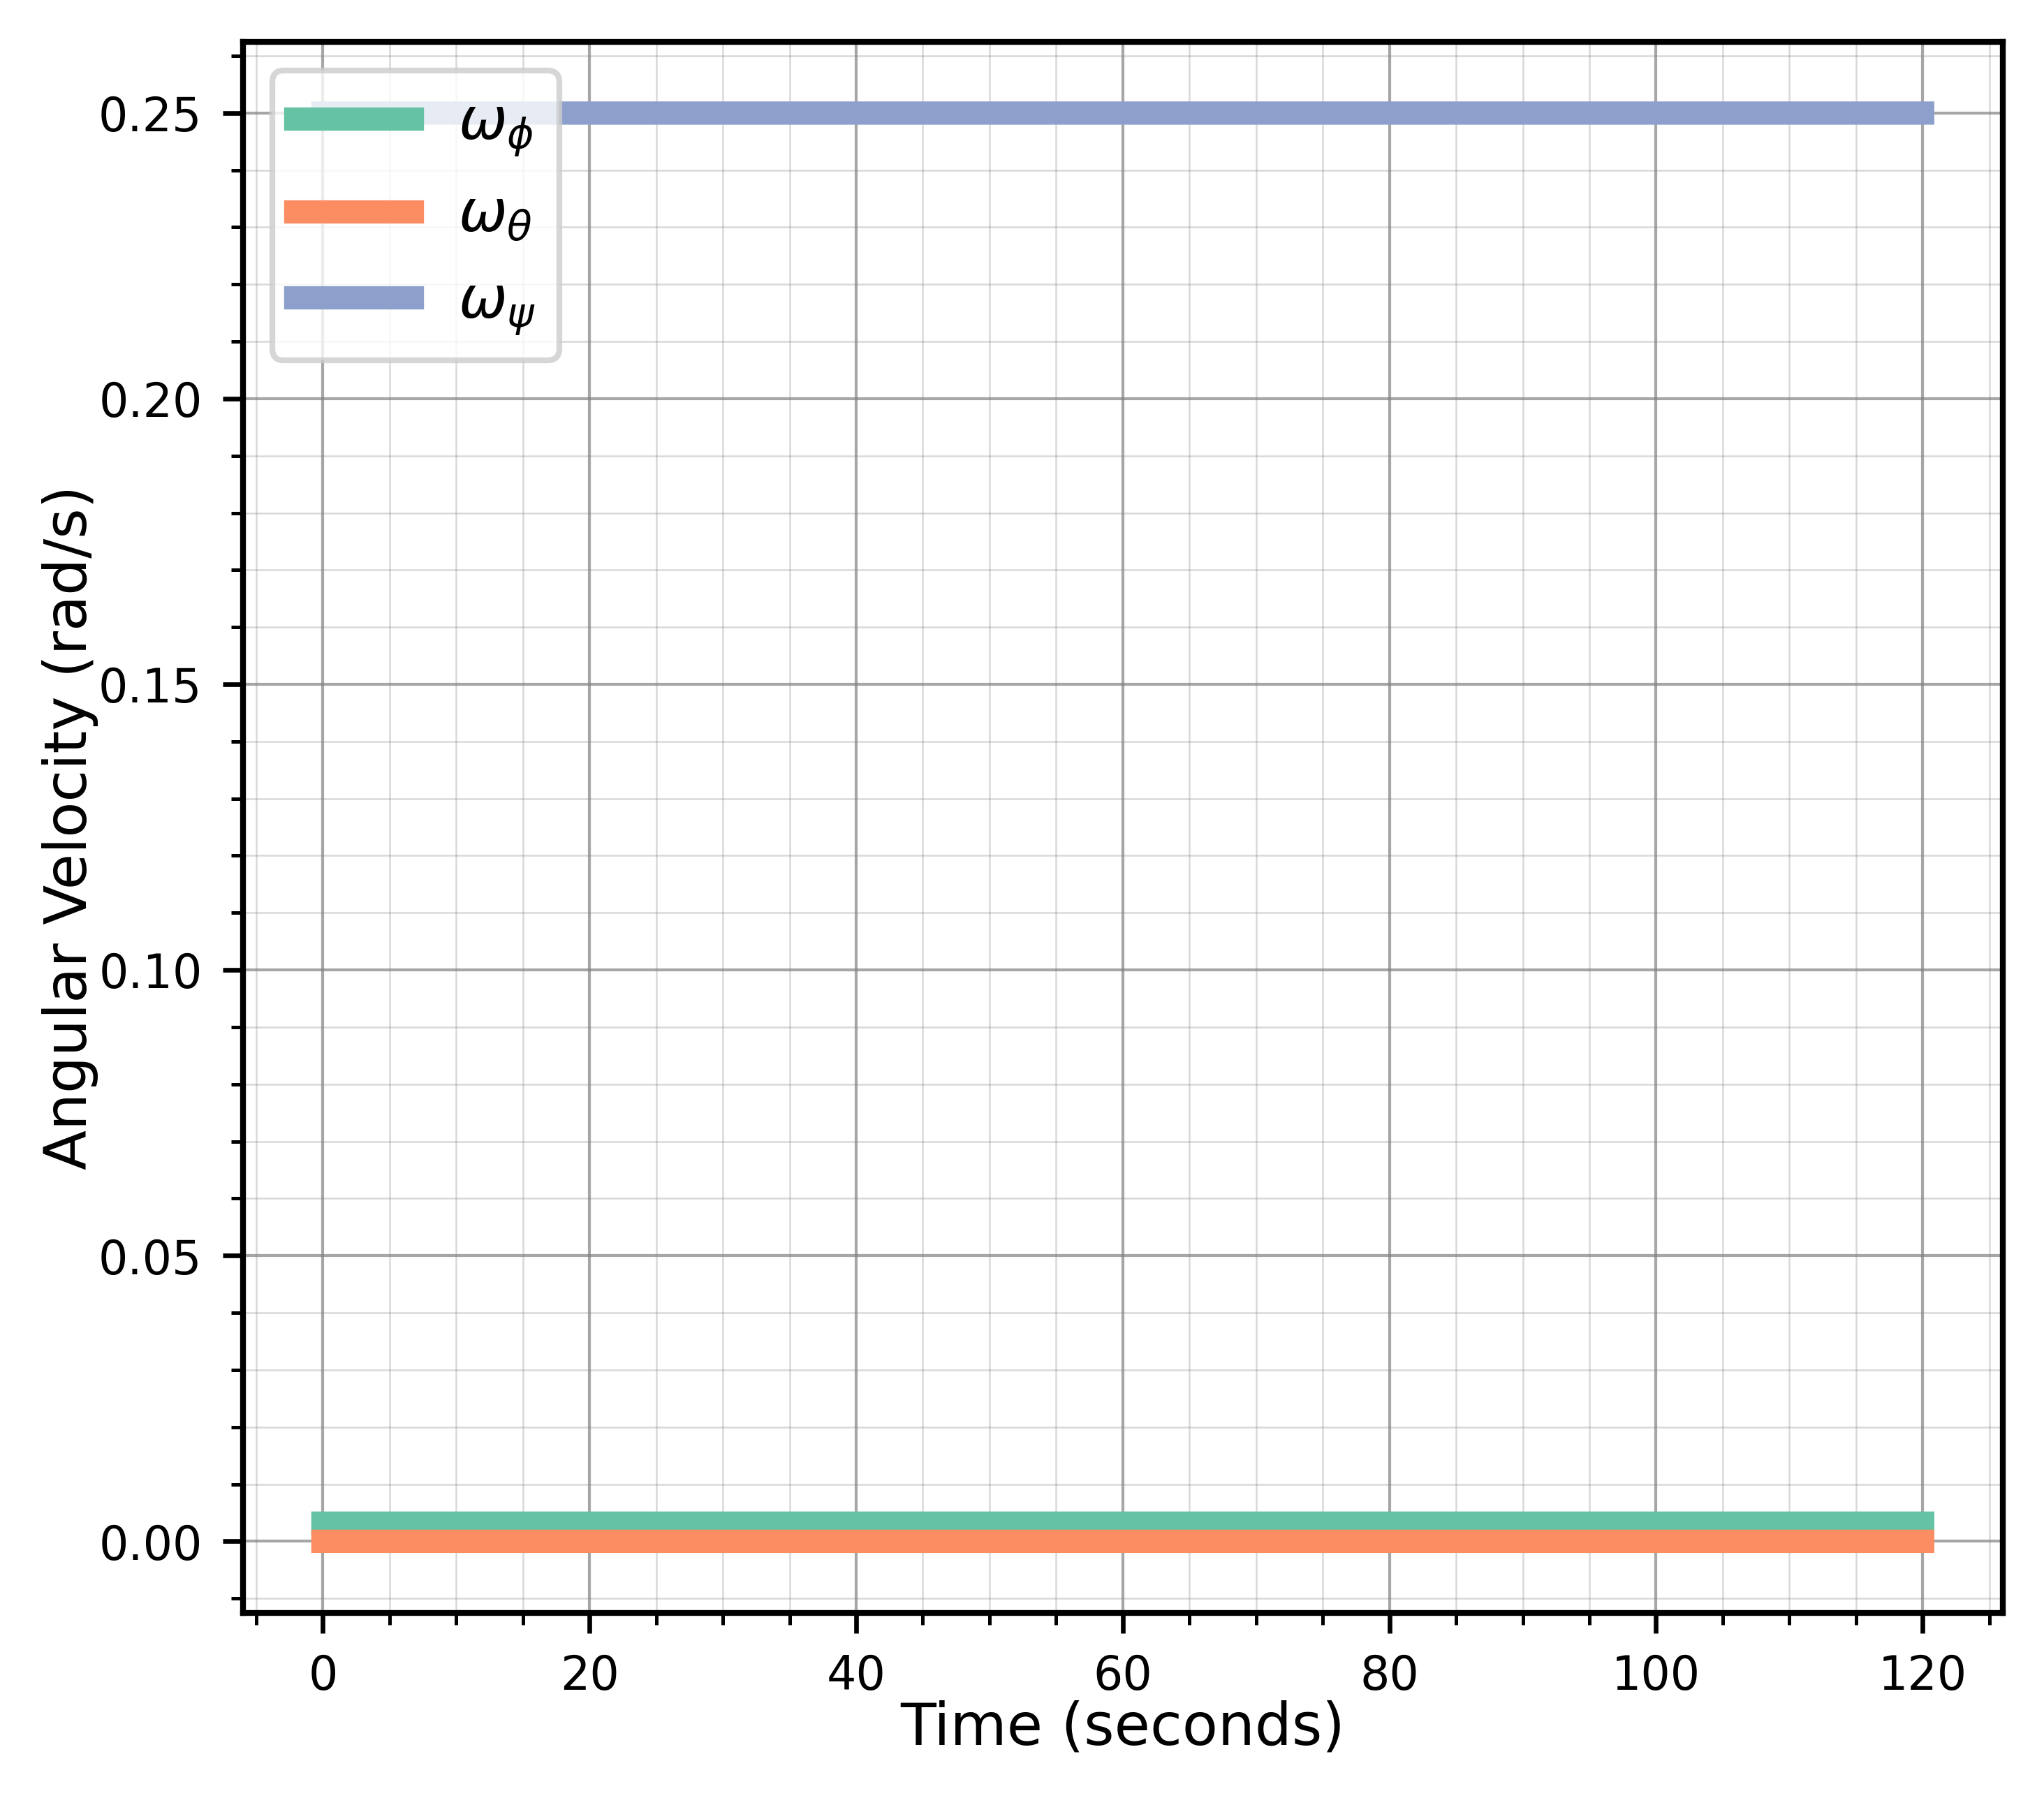

In [33]:
solutions = np.array([sol.y[9], sol.y[10], sol.y[11]])
labels = ["$\omega_\phi$", "$\omega_\\theta$", "$\omega_\psi$"]
y = (0.05, 0.01)
motion_plot("Angular Velocity (rad/s)", sol.t, solutions, labels, colors, y)